<a href="https://colab.research.google.com/github/SicilianoBartolomeo/Human-activity-recognition/blob/main/HAR2_WISDM_0%2C8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from operator import imod
import pandas as pd
import numpy as np
import tensorflow as tf
import keras as krs
from keras import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, Conv1D, Bidirectional, LSTM
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn
from sklearn.model_selection import train_test_split
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [ ]:
import random
seed=42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from datetime import datetime


experiment_time = datetime.now().isoformat()
folder_name = str(experiment_time).replace(":","_")[0:19]
folder_name

configuration_file_name = 'configuration.txt'

In [ ]:
dataset_path = 'DatasetUniba.csv'
columns_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

In [ ]:
X_column_names = ['x_axis','y_axis','z_axis']
y_column_name = 'activity'

In [ ]:
classes_to_consider = ['lying','sitting','standing','walking','ironing']

In [ ]:
classes_to_consider = ['lying','sitting','standing','walking','running',
     'cycling','NordicWalking', 'ascendingStairs', 'descendingStairs',
    'vacuumCleaning','ironing','houseCleaning','ropeJumping']

In [ ]:
classes_to_consider = ['lying','sitting','standing','walking','running',
     'cycling','NordicWalking', 'ascendingStairs', 'descendingStairs',
    'vacuumCleaning','ironing']

In [ ]:
classes_to_rename = {
     1:'lying',
     2:'sitting',
     3:'standing',
     4:'walking',
     5:'running',
     6: 'cycling',
     7:'NordicWalking',
     9: 'watchingTV',
     10: 'computerWork',
     11: 'carDriving',
    12: 'ascendingStairs',
    13: 'descendingStairs',
    16:'vacuumCleaning',
    17:'ironing',
    18:'foldingLaundry',
    19:'houseCleaning',
    20:'playingSoccer',
    24:'ropeJumping',
    0:'other'
}

In [ ]:
time_steps_list = [600]
step_list =  [100]
use_magnitude = False
aggregate_falls = True
use_speed=True
use_total_speed=False
use_timestamp=False
use_squared_components=True
use_squared_speed=True
use_sign_speed=False
use_position=False

In [ ]:
leave_one_subject_out = True
stratified_test_set = False
leave_one_subject_out_with_validation_users = False
bilstm_one_subject_out = True

use_stats_in_cnn=False

In [ ]:
save_features = False

In [ ]:
batchsize = 512

In [ ]:
from os import mkdir
mkdir(folder_name)

In [ ]:
config_file = open(folder_name + "/" + configuration_file_name,"a")
config_file.write("dataset: " + dataset_path +
"time_steps_list: " + str(time_steps_list) + 
"\nstep_list:" + str(step_list)+
"\nuse_magnitude: "+str(use_magnitude)+
"\naggregate_falls: "+str(aggregate_falls)+
"\nuse_speed: "+str(use_speed)+
"\nuse_total_speed: "+str(use_total_speed)+
"\nuse_timestamp: "+str(use_timestamp)+
"\nuse_squared_components: "+str(use_squared_components)+
"\nuse_squared_speed: "+str(use_squared_speed)+
"\nuse_sign_speed: "+str(use_sign_speed)+
"\nuse_position: "+str(use_position)
)
config_file.close()

# Kaggle dataset

In [ ]:
classes_to_rename = {
     1: 'StandingStill',
     2: 'SittingAndRelaxing',
     3: 'LyingDown',
     4: 'Walking',
     5: 'ClimbingStairs',
     6: 'WaistBendsForward',
     7: 'FrontalElevationOfArms',
     8: 'KneesBending',
     9: 'Cycling',
     10: 'Jogging',
     11: 'Running',
     12: 'JumpFrontBack',
     0: 'null'
}

In [ ]:
classes_to_consider = ['StandingStill','SittingAndRelaxing',
     'LyingDown', 'Walking','ClimbingStairs', 'WaistBendsForward',
     'FrontalElevationOfArms','KneesBending','Cycling',
     'Jogging','Running','JumpFrontBack']

In [ ]:
import os
import pandas as pd
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00319/MHEALTHDATASET.zip
!unzip MHEALTHDATASET.zip

In [ ]:
!cat MHEALTHDATASET/README.txt

In [ ]:
for i in os.listdir('MHEALTHDATASET/'):
  if i not in ('README.txt'):
    print(i)

In [ ]:
df = pd.DataFrame()
#loop to combine all data
for i in range(1,11):
    df1 = pd.read_csv(f'MHEALTHDATASET/mHealth_subject{i}.log', header=None, sep='\t')
    df1 = df1.loc[:, [14,15,16,23]]
    df1 = df1.rename(columns={
         14:"x_axis",15:"y_axis", 16:"z_axis", 23:"activity"
        })
    df1['user_id'] = i
    df = pd.concat([df,df1])

In [ ]:
df

,x_axis,y_axis,z_axis,Activity
0,-8.6499,-4.5781,0.187760,0
1,-8.6275,-4.3198,0.023595,0
2,-8.5055,-4.2772,0.275720,0
3,-8.6279,-4.3163,0.367520,0
4,-8.7008,-4.1459,0.407290,0
...,...,...,...,...
98299,-3.7198,-8.9071,0.294230,0
98300,-3.7160,-8.7455,0.448140,0
98301,-3.8824,-9.1155,0.450480,0
98302,-3.5564,-9.1441,0.594880,0


# WISDM Dataset

In [ ]:
classes_to_rename = {
    'A': 'walking',
    'B': 'jogging',
    'C': 'stairs',
    'D': 'sitting',
    'E': 'standing',
    'F': 'typing',
    'G': 'teeth',
    'H': 'soup',
    'I': 'chips',
    'J': 'pasta',
    'K': 'drinking',
    'L': 'sandwich',
    'M': 'kicking',
    'O': 'catch',
    'P': 'dribbling',
    'Q': 'writing',
    'R': 'clapping',
    'S': 'folding'
}

In [ ]:
classes_to_consider = ['walking','jogging','stairs','sitting','standing',
    'typing', 'teeth','soup','chips','pasta','drinking','sandwich',
    'kicking','catch','dribbling','writing', 'clapping','folding']

In [ ]:
!sudo echo -ne '\n' | sudo add-apt-repository ppa:alessandro-strada/ppa >/dev/null 2>&1 # note: >/dev/null 2>&1 is used to supress printing
!sudo apt update >/dev/null 2>&1
!sudo apt install google-drive-ocamlfuse >/dev/null 2>&1
!google-drive-ocamlfuse
!sudo apt-get install w3m >/dev/null 2>&1 # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop >/dev/null 2>&1 # to set default browser 
%cd /content
!mkdir gdrive
%cd gdrive
!mkdir "My Drive"
!google-drive-ocamlfuse "/content/gdrive/My Drive"

/usr/bin/xdg-open: 851: /usr/bin/xdg-open: www-browser: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links2: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: elinks: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: lynx: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force&state=Q2ovnWj9MjcJSeVbCOH%2FjZW5xWMqBCpLDKfB2Ix0UYc'
/bin/sh: 1: firefox: not found
/bin/sh: 1: google-chrome: not found
/bin/sh: 1: chromium-browser: not found
/bin/sh: 1: open: not found
Cannot retrieve auth tokens.
Failure("Error opening URL:https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

MessageError: ignored

In [ ]:
df = pd.DataFrame()
#loop to combine all data
for i in range(1600,1650):

    df1 = pd.read_csv(f'/content/gdrive/My Drive/wisdm-dataset/raw/watch/accel/data_{i}_accel_watch.txt', header=None, sep=',')
    #df1 = df1.loc[:, [0,1,2,3,4,5]]
    df1 = df1.rename(columns={
         0: 'user_id', 1: 'activity', 2: 'timestamp',
             3:'x_axis', 4: 'y_axis', 5: 'z_axis'
        })
    df = pd.concat([df,df1])

In [ ]:
df['z_axis'] = df['z_axis'].str.replace('\;*$', '', regex=True)
#df['z_axis'].apply(lambda x: float(x))
df['z_axis'] = df['z_axis'].astype(float)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1643619 entries, 0 to 71271
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1643619 non-null  int64  
 1   activity   1643619 non-null  object 
 2   timestamp  1643619 non-null  int64  
 3   x_axis     1643619 non-null  float64
 4   y_axis     1643619 non-null  float64
 5   z_axis     1643619 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 87.8+ MB


# Primo Dataset

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%cd gdrive/MyDrive
%ls

/content/gdrive/MyDrive
'Colab Notebooks'/   garbage_dataset/   Protocol/


In [ ]:
def load(dataset_path,id):
  columns=[]
  for i in range(54):
    columns.append(str(i))
  columns
  df = pd.read_csv(dataset_path, names=columns, delim_whitespace=True)
  df=df[['0','1','4','5','6']]
  df = df.rename({'0': 'timestamp', '1': 'activity', '4': 'x_axis',
                 '5': 'y_axis', '6': 'z_axis'}, axis=1) 
  df.insert(0, "user_id", id, True)
  return df

In [ ]:
#dataset_path = '/content/Dataset/subject10'
dataset_path = '/content/gdrive/MyDrive/Protocol/subject10'
path = []
num_user = 9

for i in range(num_user):
  if i != 0 and i!=3:
    path.append(dataset_path + str(i) + '.dat')

In [ ]:
#load data subject by subject
column_names = ['user_id','timestamp', 'activity', 'x_axis','y_axis', 'z_axis']
df = pd.DataFrame(columns=column_names)
i=1
for x in path:
  #pd.concat(df, load(x,i))
  df = pd.concat([df, load(x,i)], ignore_index=True)
  i+=1


# Caricamento dati

In [ ]:
df = df.dropna()

In [ ]:
df.isnull().sum()

user_id      0
activity     0
timestamp    0
x_axis       0
y_axis       0
z_axis       0
dtype: int64

In [ ]:
df.head(10)

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,1600,A,90426708196641,7.091625,-0.591667,8.195502
1,1600,A,90426757696641,4.972757,-0.158317,6.6967316
2,1600,A,90426807196641,3.253720,-0.191835,6.107758
3,1600,A,90426856696641,2.801216,-0.155922,5.997625
4,1600,A,90426906196641,3.770868,-1.051354,7.731027
5,1600,A,90426955696641,4.661511,0.169689,9.684695
6,1600,A,90427005196641,6.145916,0.832883,11.003901
7,1600,A,90427054696641,7.259220,-0.792780,11.485135
8,1600,A,90427104196641,7.354988,-2.535759,11.454011
9,1600,A,90427153696641,7.319075,-2.700959,11.461193


In [ ]:
df.sample(10)

,user_id,activity,timestamp,x_axis,y_axis,z_axis
101893,1629,K,379321564632449,3.397971,-7.316980,5.4617724;
40871,1628,J,912033330976107,3.517382,8.925284,-2.4628854;
51238,1612,P,7416767220606,2.814833,-12.155811,6.133945;
51060,1613,P,615955665554223,16.543634,9.867253,-1.4404116;
35549,1643,J,711697425727713,-4.135086,-5.862652,5.199907;
28658,1648,H,2529817622824177,8.890120,-3.937414,0.61650693;
57921,1649,Q,2720839886399455,-0.043545,-11.046398,0.07451953;
35580,1610,J,18181605516702,-1.359308,-7.120954,6.2744546;
38203,1621,I,180211771725794,-9.466824,-1.331775,-2.0376153;
63016,1649,S,2721172785907260,8.187721,-8.695291,-3.0116065;


In [ ]:
df.describe()

,user_id,timestamp,x_axis,y_axis
count,3.777046e+06,3.777046e+06,3.777046e+06,3.777046e+06
mean,1.626367e+03,6.072131e+14,3.831725e-01,-4.478842e+00
std,1.441509e+01,6.783433e+14,6.965694e+00,5.327486e+00
min,1.600000e+03,1.622154e+12,-7.063152e+01,-7.847761e+01
25%,1.614000e+03,8.371907e+13,-4.889259e+00,-8.045864e+00
50%,1.628000e+03,3.512653e+14,-4.186860e-01,-4.567987e+00
75%,1.639000e+03,9.100427e+14,5.705233e+00,-1.589451e+00
max,1.650000e+03,2.724599e+15,5.211323e+01,3.560197e+01


In [ ]:
df['activity']=df['activity'].apply(lambda x: classes_to_rename[x] if x in classes_to_rename.keys() else x)

In [ ]:
df = df[df['activity'].isin(classes_to_consider)]
df.reset_index(drop=True, inplace=True)

In [ ]:
df['activity'].unique()

array(['walking', 'jogging', 'stairs', 'sitting', 'standing', 'typing',
       'teeth', 'soup', 'chips', 'pasta', 'drinking', 'sandwich',
       'kicking', 'catch', 'dribbling', 'writing', 'clapping', 'folding'],
      dtype=object)

In [ ]:
df['activity'].unique()

array(['lying', 'sitting', 'standing', 'walking'], dtype=object)

In [ ]:
df.sample(10)

,user_id,activity,timestamp,x_axis,y_axis,z_axis
3007437,1640,typing,168074316741000,1.904041,-3.194956,-8.947793;
883955,1613,chips,614450455639521,-6.804621,-6.674286,0.86759883;
3527081,1647,sitting,726041302340550,-1.798345,-3.694104,8.59249;
513539,1607,writing,113957094075165,-0.585233,-8.865729,3.5019689;
2634875,1637,clapping,10988704940000,8.868757,-2.509981,4.598438;
3426282,1645,sandwich,1132620383891536,-1.090709,-3.804536,8.690803;
499999,1607,sandwich,118206614792130,9.553015,-1.423203,2.7907414;
870621,1613,standing,612615964904168,2.949357,-3.722235,8.6774845;
1775601,1626,folding,370840380154281,-10.235662,-0.216376,2.5219922;
547203,1608,teeth,726183417468174,-7.560889,-6.375011,5.5027733;


In [ ]:
import math

if use_magnitude:
    df['magnitude'] = np.sqrt(np.power(df['x_axis'],2) + np.power(df['y_axis'],2) + np.power(df['z_axis'],2))
    X_column_names.append('magnitude')
df.sample(10)

,user_id,activity,timestamp,x_axis,y_axis,z_axis
80287,2,Walking,4560,-0.299662,-10.027537,0.869551
244360,6,Hopping,8665,-1.436161,0.074990,0.506077
68534,2,Jogging,1290,0.512122,-19.916449,1.170201
569240,15,Hopping,2560,1.413376,7.428269,0.282830
478365,12,Walking,1170,0.966936,7.791567,0.030316
428576,11,Hopping,8795,0.356096,-6.497741,-3.009370
572455,15,Hopping,3605,-4.072380,7.862972,0.074416
569350,15,Hopping,3110,-1.546647,0.218972,-0.908295
658129,17,Sitting,9390,0.297272,2.086763,-7.592010
97757,3,Fall,5275,-5.380082,-0.002115,5.534460


In [ ]:
classes = df['activity'].unique()
classes

array(['walking', 'jogging', 'stairs', 'sitting', 'standing', 'typing',
       'teeth', 'soup', 'chips', 'pasta', 'drinking', 'sandwich',
       'kicking', 'catch', 'dribbling', 'writing', 'clapping', 'folding'],
      dtype=object)

In [ ]:
classes = df['activity'].unique()
classes

array(['lying', 'sitting', 'standing', 'walking'], dtype=object)

In [ ]:
if use_speed:
    records = []

    for index, row in df.iterrows():
        record = dict()
        if index==0 or (row['activity'])!=(df.iloc[index-1]['activity']):
            record['id']=index
            record['timestamp']=row['timestamp']
            record['v_x']=0
            record['v_y']=0
            record['v_z']=0
            record['x']=0
            record['y']=0
            record['z']=0
            record['v']=0
        else:
            prev_row = df.iloc[index-1]
            prev_record = records[-1]
            delta_t=(float(row['timestamp'])-float(prev_row['timestamp']))/1000
            record['id']=index
            record['timestamp']=row['timestamp']
            vx=float(prev_record['v_x'])+float(prev_row['x_axis'])*delta_t
            vy=float(prev_record['v_y'])+float(prev_row['y_axis'])*delta_t
            vz=float(prev_record['v_z'])+float(prev_row['z_axis'])*delta_t
            record['v_x']=vx
            record['v_y']=vy
            record['v_z']=vz
            x = float(prev_record['x']) + float(prev_record['v_x'])*delta_t + 0.5*float(prev_row['x_axis'])*(delta_t*delta_t)
            y = float(prev_record['x']) + float(prev_record['v_y'])*delta_t + 0.5*float(prev_row['y_axis'])*(delta_t*delta_t)
            z = float(prev_record['x']) + float(prev_record['v_z'])*delta_t + 0.5*float(prev_row['z_axis'])*(delta_t*delta_t)
            record['x']=x
            record['y']=y
            record['z']=z
            record['v']=np.sqrt(np.power(vx,2) + np.power(vy,2) + np.power(vz,2))
        records.append(record)

    df_velocità = pd.DataFrame(records, columns=['id','v_x','v_y','v_z','v','x','y','z'])
    df = pd.concat([df, df_velocità], axis=1).drop(columns=['id'])
    X_column_names+=['v_x','v_y','v_z','v']
    if not use_total_speed:
        X_column_names.remove('v')
    if use_position:
        X_column_names+=['x','y','z']
    df_velocità.head()

In [ ]:
df.head()

,user_id,timestamp,activity,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z
0,1,37.66,lying,2.21530,8.27915,5.58753,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1,1,37.67,lying,2.29196,7.67288,5.74467,0.000022,0.000083,0.000056,0.000102,1.107650e-10,4.139575e-10,2.793765e-10
2,1,37.68,lying,2.29090,7.14240,5.82342,0.000045,0.000160,0.000113,0.000201,4.468930e-10,1.322324e-09,9.567515e-10
3,1,37.69,lying,2.21800,7.14365,5.89930,0.000068,0.000231,0.000172,0.000296,1.012164e-09,2.399216e-09,1.871284e-09
4,1,37.70,lying,2.30106,7.25857,6.09259,0.000090,0.000302,0.000231,0.000391,1.802880e-09,3.678790e-09,3.022691e-09


In [ ]:
if use_squared_components:
    df['x_axis_squared'] = np.square(df['x_axis'])
    df['y_axis_squared'] = np.square(df['y_axis'])
    df['z_axis_squared'] = np.square(df['z_axis'])
    X_column_names+=['x_axis_squared', 'y_axis_squared','z_axis_squared']

if use_squared_speed:
    df['vx2'] = np.square(df['v_x'])
    df['vy2'] = np.square(df['v_y'])
    df['vz2'] = np.square(df['v_z'])
    X_column_names+=['vx2','vy2','vz2']

if use_sign_speed:
    df['signvx']= np.sign(df['v_x'])  #df['v_x']/(np.abs(df['v_x'])+1)
    df['signvy']= np.sign(df['v_y'])  #df['v_y']/(np.abs(df['v_y'])+1)
    df['signvz']= np.sign(df['v_z'])  #df['v_z']/(np.abs(df['v_z'])+1)
    X_column_names+=['signvx','signvy','signvz']

In [ ]:
users_ids = df['user_id'].unique()
users_number = len(users_ids)
print("Numero totale di utenti:",users_number)

Numero totale di utenti: 50


In [ ]:
users_ids = df['user_id'].unique()
users_number = len(users_ids)
print("Numero totale di utenti:",users_number)

Numero totale di utenti: 8


In [ ]:
user_original_data = dict() #dict {user_id: dataframe_dati_utente_originali}
for users_id in users_ids:
    user_original_data[users_id]=df[df['user_id']==users_id]

In [ ]:
user_original_data.keys()

dict_keys([1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649])

In [ ]:
user_original_data[1600]

,user_id,activity,timestamp,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z,x_axis_squared,y_axis_squared,z_axis_squared,vx2,vy2,vz2
0,1600,walking,90426708196641,7.091625,-0.591667,8.195502,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,50.291145,0.350070,67.166253,0.000000e+00,0.000000e+00,0.000000e+00
1,1600,walking,90426757696641,4.972757,-0.158317,6.696732,3.510354e+05,-2.928752e+04,4.056773e+05,5.372688e+05,8.688127e+09,-7.248662e+08,1.004051e+10,24.728312,0.025064,44.846214,1.232259e+11,8.577589e+08,1.645741e+11
2,1600,walking,90426807196641,3.253720,-0.191835,6.107758,5.971869e+05,-3.712419e+04,7.371656e+05,9.494332e+05,3.215663e+10,7.044437e+09,3.697349e+10,10.586694,0.036801,37.304708,3.566322e+11,1.378206e+09,5.434131e+11
3,1600,walking,90426856696641,2.801216,-0.155922,5.997625,7.582460e+05,-4.662005e+04,1.039500e+06,1.287505e+06,6.570360e+10,3.008396e+10,7.612909e+10,7.846811,0.024312,35.971506,5.749371e+11,2.173429e+09,1.080559e+12
4,1600,walking,90426906196641,3.770868,-1.051354,7.731027,8.969062e+05,-5.433820e+04,1.336382e+06,1.610376e+06,1.066686e+11,6.320488e+10,1.245067e+11,14.219442,1.105345,59.768778,8.044408e+11,2.952640e+09,1.785917e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65457,1600,folding,82724332877212,3.271527,-7.406313,-1.863736,-5.229826e+08,-1.039060e+09,2.013610e+08,1.180552e+09,-4.574550e+16,-4.577125e+16,-4.570932e+16,10.702889,54.853478,3.473513,2.735108e+17,1.079646e+18,4.054624e+16
65458,1600,folding,82724382807252,4.720019,-5.680094,-5.270685,-5.228193e+08,-1.039430e+09,2.012679e+08,1.180789e+09,-4.577160e+16,-4.579739e+16,-4.573544e+16,22.278579,32.263468,27.780120,2.733400e+17,1.080415e+18,4.050877e+16
65459,1600,folding,82724432737292,8.126968,-8.143727,-5.076755,-5.225836e+08,-1.039714e+09,2.010048e+08,1.180890e+09,-4.579770e+16,-4.582351e+16,-4.576156e+16,66.047609,66.320289,25.773441,2.730936e+17,1.081004e+18,4.040291e+16
65460,1600,folding,82724482667332,7.542783,-8.885930,-3.630657,-5.221778e+08,-1.040120e+09,2.007513e+08,1.181025e+09,-4.582379e+16,-4.584963e+16,-4.578767e+16,56.893575,78.959752,13.181672,2.726697e+17,1.081850e+18,4.030107e+16


In [ ]:
from scipy import stats
def create_sliding_windows(data, time_steps=1, step=1):
  Xs = []
  for i in range(0, len(data) - time_steps, step):
    v = data.iloc[i: (i+time_steps)]
    

    Xs.append(v)
    
  return Xs

In [ ]:
user_trials = dict() #dict {user id: lista di trial dell'utente}

for users_id in users_ids:
    original_data = user_original_data[users_id]
    original_data.reset_index(inplace=True)
    #troviamo gli indici dei record iniziale di ogni trial (timestamp=0)
    index_start_trial = [0]
    for index, row in original_data.iterrows():
        if index==0:
            continue
        #if int(row['activity'])!=int(original_data.iloc[index-1]['activity']):
        if (row['activity'])!=(original_data.iloc[index-1]['activity']):
           # print("ok")
            index_start_trial.append(index)
    trials = []
    for i in range(len(index_start_trial)-1):
        trials.append(original_data.iloc[index_start_trial[i]:index_start_trial[i+1]-1])
    trials.append(original_data.iloc[index_start_trial[len(index_start_trial)-1]:])
    user_trials[users_id]=trials

In [ ]:
user_trials[3][2]

,index,x_axis,y_axis,z_axis,activity,user_id
6144,76850,-3.9965,4.5835,8.3542,LyingDown,3
6145,76851,-4.1338,4.6524,8.2430,LyingDown,3
6146,76852,-3.6495,4.6610,8.0976,LyingDown,3
6147,76853,-3.2419,4.7016,8.1622,LyingDown,3
6148,76854,-3.2217,4.7912,8.1250,LyingDown,3
...,...,...,...,...,...,...
9210,79916,-3.0977,4.2550,7.5044,LyingDown,3
9211,79917,-3.3450,4.5365,7.6539,LyingDown,3
9212,79918,-3.3622,4.7283,7.8302,LyingDown,3
9213,79919,-3.3038,4.7288,7.8823,LyingDown,3


In [ ]:
user_trials[1][4]

,index,user_id,activity,timestamp,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z,x_axis_squared,y_axis_squared,z_axis_squared,vx2,vy2,vz2
12084,12084,1,Hopping,0,0.588376,-12.244653,-3.510972,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.346186,149.931527,12.326926,0.000000,0.000000,0.000000
12085,12085,1,Hopping,5,1.688943,-12.206215,-2.763705,0.002942,-0.061223,-0.017555,0.063758,0.000007,-0.000153,-0.000044,2.852527,148.991685,7.638068,0.000009,0.003748,0.000308
12086,12086,1,Hopping,10,2.506947,-11.873831,-1.915576,0.011387,-0.122254,-0.031373,0.126728,0.000043,-0.000451,-0.000115,6.284786,140.987863,3.669431,0.000130,0.014946,0.000984
12087,12087,1,Hopping,15,2.959034,-11.462978,-1.201675,0.023921,-0.181623,-0.040951,0.187713,0.000131,-0.000717,-0.000138,8.755883,131.399865,1.444022,0.000572,0.032987,0.001677
12088,12088,1,Hopping,20,2.914835,-11.029402,-0.691599,0.038717,-0.238938,-0.046960,0.246568,0.000288,-0.000920,-0.000088,8.496264,121.647708,0.478309,0.001499,0.057092,0.002205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15079,15079,1,Hopping,14975,2.127361,-11.436087,-2.435742,-3.538412,-118.765564,-10.719030,119.300784,-26.787007,-27.362944,-26.822841,4.525665,130.784086,5.932839,12.520362,14105.259085,114.897597
15080,15080,1,Hopping,14980,1.024550,-10.493032,-2.617908,-3.527776,-118.822744,-10.731208,119.358487,-26.804673,-27.380978,-26.840633,1.049702,110.103710,6.853443,12.445200,14118.844488,115.158833
15081,15081,1,Hopping,14985,-0.181768,-9.692158,-2.784552,-3.522653,-118.875209,-10.744298,119.411743,-26.822299,-27.398918,-26.858362,0.033040,93.937927,7.753732,12.409083,14131.315348,115.439938
15082,15082,1,Hopping,14990,-1.502831,-9.059606,-2.907250,-3.523562,-118.923670,-10.758221,119.461266,-26.839915,-27.416796,-26.876055,2.258501,82.076461,8.452105,12.415486,14142.839270,115.739312


In [ ]:
sliding_w_by_timestep=dict() #[timestep][steps][userid][indice trial][indice sliding window]

for time_steps in time_steps_list:
    sliding_w_by_step=dict()
    for step in step_list:
        user_sliding_windows = dict()  #[userid][indice trial][indice sliding window]
        for user_id in users_ids:
            user_trial_list = user_trials[user_id]
            num_trials = len(user_trial_list)  
            list_sliding_windows = []  
            for i in range(num_trials):
                trial = user_trial_list[i]
                sliding_window = create_sliding_windows(trial, time_steps, step)
                list_sliding_windows.append(sliding_window)
            user_sliding_windows[user_id]=list_sliding_windows    
        sliding_w_by_step[step]=user_sliding_windows
    sliding_w_by_timestep[time_steps]=sliding_w_by_step  

In [ ]:
trial

,index,x_axis,y_axis,z_axis,activity,user_id
32666,342171,-1.48750,-0.38290,-0.289980,JumpFrontBack,10
32667,342172,-1.67190,-0.78675,0.325250,JumpFrontBack,10
32668,342173,-0.49839,-1.52550,0.454980,JumpFrontBack,10
32669,342174,0.32067,-2.25940,0.064115,JumpFrontBack,10
32670,342175,-0.50649,-1.41980,1.022800,JumpFrontBack,10
...,...,...,...,...,...,...
33685,343190,-8.23480,-4.96520,2.480900,JumpFrontBack,10
33686,343191,-21.31800,-10.21300,3.656000,JumpFrontBack,10
33687,343192,-21.29700,-18.70500,4.460600,JumpFrontBack,10
33688,343193,-21.13800,-18.69800,1.158800,JumpFrontBack,10


In [ ]:
#esempio di trial
trial

,index,user_id,activity,timestamp,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z,x_axis_squared,y_axis_squared,z_axis_squared,vx2,vy2,vz2
33198,734724,19,Walking,0,3.905989,4.920188,3.792791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.256748,24.208250,14.385264,0.000000,0.000000,0.000000
33199,734725,19,Walking,5,3.712691,4.402665,1.453277,0.019530,0.024601,0.018964,0.036691,0.000049,0.000062,0.000047,13.784073,19.383459,2.112013,0.000381,0.000605,0.000360
33200,734726,19,Walking,10,3.388979,3.884667,-1.575216,0.038093,0.046614,0.026230,0.065666,0.000193,0.000227,0.000162,11.485179,15.090638,2.481306,0.001451,0.002173,0.000688
33201,734727,19,Walking,15,2.971400,3.394894,-3.453373,0.055038,0.066038,0.018354,0.087904,0.000426,0.000475,0.000304,8.829217,11.525303,11.925788,0.003029,0.004361,0.000337
33202,734728,19,Walking,20,2.431605,3.106119,-4.544110,0.069895,0.083012,0.001087,0.108524,0.000738,0.000798,0.000474,5.912702,9.647973,20.648938,0.004885,0.006891,0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36204,737730,19,Walking,15030,3.607614,3.775315,-1.813403,17.134446,114.826340,5.423988,116.224341,131.738458,132.226920,131.679968,13.014877,14.253006,3.288430,293.589236,13185.088461,29.419648
36205,737731,19,Walking,15035,3.749106,4.399148,-2.120795,17.152484,114.845217,5.414921,116.245228,131.824176,132.312637,131.765556,14.055792,19.352508,4.497772,294.207706,13189.423874,29.321371
36206,737732,19,Walking,15040,3.862242,5.141159,-2.582244,17.171229,114.867213,5.404317,116.269232,131.909985,132.398457,131.851224,14.916911,26.431521,6.667985,294.851122,13194.476569,29.206644
36207,737733,19,Walking,15045,3.913796,6.209425,-3.008182,17.190541,114.892919,5.391406,116.296882,131.995889,132.484385,131.936974,15.317799,38.556964,9.049159,295.514690,13200.382737,29.067258


In [ ]:
sliding_w_by_timestep[time_steps_list[0]][step_list[0]][1][0][0]

,index,x_axis,y_axis,z_axis,activity,user_id
0,0,-2.8439,-9.0618,1.8177,StandingStill,1
1,1,-2.9935,-9.2048,1.5189,StandingStill,1
2,2,-2.8846,-9.1945,1.5507,StandingStill,1
3,3,-2.9245,-9.1746,1.5413,StandingStill,1
4,4,-2.8963,-9.2039,1.6127,StandingStill,1
...,...,...,...,...,...,...
595,595,-2.9564,-8.9846,1.5404,StandingStill,1
596,596,-3.0286,-9.1732,1.6768,StandingStill,1
597,597,-3.0265,-9.1640,1.6043,StandingStill,1
598,598,-3.0468,-9.0044,1.5602,StandingStill,1


In [ ]:
#esempio di sliding window
sliding_w_by_timestep[time_steps_list[0]][step_list[0]][1][0][0]

,index,user_id,activity,timestamp,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z,x_axis_squared,y_axis_squared,z_axis_squared,vx2,vy2,vz2
0,0,1,Fall,0,-2.120995,-7.684790,-0.116293,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.498618,59.055997,0.013524,0.000000,0.000000,0.000000e+00
1,1,1,Fall,5,-1.837475,-7.524046,-0.273713,-0.010605,-0.038424,-0.000581,0.039865,-0.000027,-0.000096,-0.000001,3.376315,56.611268,0.074919,0.000112,0.001476,3.381020e-07
2,2,1,Fall,10,-1.528029,-7.397976,-0.263592,-0.019792,-0.076044,-0.001950,0.078602,-0.000103,-0.000313,-0.000033,2.334873,54.730049,0.069481,0.000392,0.005783,3.802614e-06
3,3,1,Fall,15,-1.099379,-7.245015,-0.243442,-0.027432,-0.113034,-0.003268,0.116361,-0.000221,-0.000575,-0.000116,1.208634,52.490242,0.059264,0.000753,0.012777,1.067976e-05
4,4,1,Fall,20,-0.651752,-7.112909,-0.147084,-0.032929,-0.149259,-0.004485,0.152914,-0.000371,-0.000876,-0.000240,0.424780,50.593479,0.021634,0.001084,0.022278,2.011704e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,595,1,Fall,2975,-2.325609,-0.509494,-6.871175,-5.930715,-2.537528,-12.896842,14.420158,-6.124823,-6.107881,-6.159599,5.408456,0.259584,47.213046,35.173386,6.439046,1.663285e+02
596,596,1,Fall,2980,-2.291714,-0.552084,-6.960178,-5.942344,-2.540075,-12.931197,14.456116,-6.154505,-6.137517,-6.189393,5.251955,0.304796,48.444083,35.311447,6.451981,1.672159e+02
597,597,1,Fall,2985,-2.234422,-0.602634,-7.031116,-5.953802,-2.542835,-12.965998,14.492442,-6.184246,-6.167212,-6.219248,4.992643,0.363168,49.436585,35.447759,6.466012,1.681171e+02
598,598,1,Fall,2990,-2.195272,-0.619144,-7.144061,-5.964974,-2.545849,-13.001154,14.529015,-6.214042,-6.196967,-6.249163,4.819220,0.383340,51.037602,35.580917,6.481345,1.690300e+02


In [ ]:
df_aggregate_feature_by_timestep = dict()
axes = ['x_axis','y_axis','z_axis']

for time_steps in time_steps_list:
    df_aggregate_feature_by_step = dict()
    for step in step_list:
        df_aggregate_feature_by_user = []
        for user_id in users_ids:
            df_aggregate_feature_by_trial=dict()
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                df_aggregate_feature_by_sliding_window = dict()
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    tupla = dict()
                    tupla['time_steps']=time_steps
                    tupla['step']=step
                    tupla['user_id']=user_id
                    tupla['trial']=trial
                    tupla['sliding_window']=sliding_window
                    tupla['activity']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window]['activity'].unique()[0]
                    
                    for axis in axes:
                        tupla[f'{axis}_mean']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].mean()
                        tupla[f'{axis}_devstd']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].std()
                        tupla[f'{axis}_power']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].pow(2).mean()                   
                    
                    
                    for k1, v1 in sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axes].cov().to_dict().items():
                        for k2, v2 in v1.items():
                            tupla[f"cov({k1},{k2})"]=v2

                    df_aggregate_feature_by_user.append(tupla)
                    
                    #df_aggregate_feature_by_sliding_window[sliding_window]=tupla
                #df_aggregate_feature_by_trial[trial]=df_aggregate_feature_by_sliding_window
            #df_aggregate_feature_by_user[user_id]=df_aggregate_feature_by_trial
        df_aggregate_feature_by_step[step]=pd.DataFrame(df_aggregate_feature_by_user)
    df_aggregate_feature_by_timestep[time_steps]=df_aggregate_feature_by_step


In [ ]:
df_aggregate_feature_by_timestep[time_steps_list[0]][step_list[0]]

,time_steps,step,user_id,trial,sliding_window,activity,x_axis_mean,x_axis_devstd,x_axis_power,y_axis_mean,...,z_axis_power,"cov(x_axis,x_axis)","cov(x_axis,y_axis)","cov(x_axis,z_axis)","cov(y_axis,x_axis)","cov(y_axis,y_axis)","cov(y_axis,z_axis)","cov(z_axis,x_axis)","cov(z_axis,y_axis)","cov(z_axis,z_axis)"
0,600,100,1,0,0,StandingStill,-2.913919,0.124591,8.506421,-9.137065,...,2.927027,0.015523,-0.002366,0.000483,-0.002366,0.010738,0.001293,0.000483,0.001293,0.013734
1,600,100,1,0,1,StandingStill,-2.934854,0.125581,8.629111,-9.131949,...,2.860133,0.015771,-0.002199,0.000220,-0.002199,0.010486,0.001547,0.000220,0.001547,0.014671
2,600,100,1,0,2,StandingStill,-2.956434,0.126773,8.756545,-9.129857,...,2.800738,0.016071,-0.001912,-0.000358,-0.001912,0.010785,0.002101,-0.000358,0.002101,0.013891
3,600,100,1,0,3,StandingStill,-2.969162,0.118665,8.829979,-9.132843,...,2.726334,0.014081,-0.001624,0.000299,-0.001624,0.010794,0.001464,0.000299,0.001464,0.012247
4,600,100,1,0,4,StandingStill,-2.997320,0.111062,8.996243,-9.129314,...,2.670609,0.012335,-0.000886,-0.000209,-0.000886,0.010501,0.001453,-0.000209,0.001453,0.012284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2750,600,100,10,11,0,JumpFrontBack,-6.635264,9.466314,133.488480,-4.512021,...,16.584951,89.611110,59.199037,-27.808903,59.199037,45.909004,-18.935020,-27.808903,-18.935020,12.690763
2751,600,100,10,11,1,JumpFrontBack,-6.476325,9.507916,132.192587,-4.143591,...,17.964854,90.400474,56.796421,-29.945796,56.796421,42.401329,-19.426219,-29.945796,-19.426219,13.922693
2752,600,100,10,11,2,JumpFrontBack,-6.393348,9.676111,134.345971,-4.154254,...,19.430631,93.627119,58.608675,-31.712160,58.608675,43.688705,-20.814367,-31.712160,-20.814367,15.110421
2753,600,100,10,11,3,JumpFrontBack,-6.129782,9.661786,130.768752,-3.921195,...,20.100687,93.350109,58.039478,-32.593311,58.039478,43.217231,-21.556425,-32.593311,-21.556425,15.770622


In [ ]:
df_aggregate_feature_by_timestep[time_steps_list[0]][step_list[0]]

,time_steps,step,user_id,trial,sliding_window,activity,x_axis_mean,x_axis_devstd,x_axis_power,y_axis_mean,...,z_axis_power,"cov(x_axis,x_axis)","cov(x_axis,y_axis)","cov(x_axis,z_axis)","cov(y_axis,x_axis)","cov(y_axis,y_axis)","cov(y_axis,z_axis)","cov(z_axis,x_axis)","cov(z_axis,y_axis)","cov(z_axis,z_axis)"
0,600,100,1,0,0,Fall,-1.995646,2.586167,10.659720,-0.850659,...,34.326067,6.688262,-11.273968,7.883962,-11.273968,48.027202,-11.912880,7.883962,-11.912880,15.362830
1,600,100,1,0,1,Fall,-2.506570,2.320661,11.659386,0.322977,...,42.615043,5.385467,-7.835804,6.440426,-7.835804,37.913874,-6.537518,6.440426,-6.537518,13.094506
2,600,100,1,0,2,Fall,-2.834991,2.154660,12.671999,1.210539,...,49.963273,4.642561,-5.478082,5.387755,-5.478082,30.079760,-2.515052,5.387755,-2.515052,11.709851
3,600,100,1,0,3,Fall,-2.681637,1.268671,8.798021,0.028316,...,48.912018,1.609527,0.448079,1.908640,0.448079,10.343486,3.942075,1.908640,3.942075,5.984117
4,600,100,1,0,4,Fall,-2.780770,0.637050,8.137838,-0.965211,...,55.097968,0.405833,0.181713,0.280007,0.181713,0.349389,0.280279,0.280007,0.280279,1.221111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6064,600,100,19,11,20,Walking,1.292207,3.456709,13.598721,7.433629,...,10.365817,11.948837,-12.156124,-3.774685,-12.156124,42.334281,0.577013,-3.774685,0.577013,10.344760
6065,600,100,19,11,21,Walking,1.014370,3.307303,11.948967,7.743142,...,8.668293,10.938251,-10.637709,-3.296705,-10.637709,35.119576,1.569864,-3.296705,1.569864,8.580417
6066,600,100,19,11,22,Walking,1.108906,3.723469,15.070783,7.590312,...,11.124517,13.864219,-10.310074,-4.555707,-10.310074,35.943224,1.771720,-4.555707,1.771720,11.067935
6067,600,100,19,11,23,Walking,1.058964,3.336957,12.238129,7.646630,...,8.024758,11.135283,-7.342637,-3.218866,-7.342637,24.065938,2.156671,-3.218866,2.156671,7.801633


In [ ]:
import itertools

if save_features:
    for config in itertools.product(time_steps_list, step_list):
        time_step = config[0]
        step = config[1]
        
        example_list = []
        data = sliding_w_by_timestep[time_step][step]
        for user_id in users_ids:
            for trial in range(len(data[user_id])):
                for sliding_window in range(len(data[user_id][trial])):
                    for index, row in data[user_id][trial][sliding_window].iterrows():
                        item = row.to_dict()
                        item.update({'trial':trial,'sliding_window':sliding_window})
                        example_list.append(item)
        example_df = pd.DataFrame(example_list, columns=['trial','sliding_window']+list(sliding_w_by_timestep[time_step][step][users_ids[0]][0][0].columns))
        example_df.drop(columns="index", inplace=True)
        example_df.to_csv(f"{dataset_path.split('.')[0]}_{time_step}_{step}.csv")

In [ ]:
tuple_by_timestep=dict()
for time_steps in time_steps_list:
    tuple_by_step=dict()
    for step in step_list:
        tuple = dict()

        for user_id in users_ids:
            Xs = []
            ys = []
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    Xs.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][X_column_names]))
                    ys.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][y_column_name].unique()))
            tuple[user_id]=(Xs,ys)
        tuple_by_step[step]=tuple
    tuple_by_timestep[time_steps]=tuple_by_step        

In [ ]:
ignore_columns = ['time_steps', 'step', 'user_id', 'trial', 'activity', 'sliding_window']

tuple_by_timestep_with_stats=dict()
for time_steps in time_steps_list:
    tuple_by_step=dict()
    for step in step_list:
        tuple = dict()
        actual_df_stats = df_aggregate_feature_by_timestep[time_steps][step]
        feature_columns = [col_name for col_name in list(actual_df_stats.columns.values) if not col_name in ignore_columns]
        for user_id in users_ids:
            Xs = []
            ys = []
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    raw_and_feature = np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][X_column_names]).flatten().reshape(-1,1)
                    actual_row_stats = actual_df_stats.loc[(actual_df_stats['time_steps']==time_steps) & (actual_df_stats['step']==step) & (actual_df_stats['user_id']==user_id) & (actual_df_stats['trial']==trial) &(actual_df_stats['sliding_window']==sliding_window)]
                    aggregate_feature = np.array(actual_row_stats[feature_columns]).reshape(-1,1)
                    #aggregate_feature = np.array(list(df_aggregate_feature_by_timestep[time_steps][step][user_id][trial][sliding_window].values())[2:]).reshape(-1,1)
                    Xs.append(np.concatenate((raw_and_feature,aggregate_feature),axis=0))
                    ys.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][y_column_name].unique()))
            tuple[user_id]=(Xs,ys)
        tuple_by_step[step]=tuple
    tuple_by_timestep_with_stats[time_steps]=tuple_by_step     

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives/ (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# CNN

In [ ]:
cnn_dir = folder_name + "\\cnn"
leave_one_subject_out_dir = "\\leave_one_subject_out"
leave_one_subject_out_with_validation_user_dir =  "\\leave_one_subject_out_with_validation_user"
stratified_dir = "\\stratified"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

mkdir(cnn_dir )


In [ ]:
def createCNN(input_size, output_size):
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape = input_size))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy',f1_m])

    cnn_config_file = open(cnn_dir+config_filename, "a")
    model.summary(print_fn=lambda x: cnn_config_file.write(x))
    cnn_config_file.close()
    
    return model

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(np.array(classes).reshape(-1,1))

In [ ]:
import gc
gc.collect()

0

In [ ]:
if use_stats_in_cnn:
    data_cnn = tuple_by_timestep_with_stats
else:
    data_cnn = tuple_by_timestep

## CNN - Leave One Subject Out

In [ ]:
notConsider = [1601,1603,1607,1608,1609,1612,1613,1617,1618,1620,1621,1622,1624,1628,1629,1633,1636,1637,1638,1639,1640,1642,1644,1648]

600 100
Utente test:  1600
Training: x-> 25437 y-> 25437
Validation: x-> 6360 y-> 6360
Testing: x-> 563 y-> 563
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 15s 34ms/step - loss: 2.1735 - accuracy: 0.2876 - f1_m: 0.1502 - val_loss: 1.6935 - val_accuracy: 0.4404 - val_f1_m: 0.2862
Epoch 2/100
199/199 [==============================] - 6s 32ms/step - loss: 1.5519 - accuracy: 0.4738 - f1_m: 0.3728 - val_loss: 1.3389 - val_accuracy: 0.5404 - val_f1_m: 0.4479
Epoch 3/100
199/199 [==============================] - 6s 31ms/step - loss: 1.3192 - accuracy: 0.5502 - f1_m: 0.4800 - val_loss: 1.1420 - val_accuracy: 0.6057 - val_f1_m: 0.5575
Epoch 4/100
199/199 [==============================] - 6s 31ms/step - loss: 1.1944 - accuracy: 0.5895 - f1_m: 0.5370 - val_loss: 1.1070 - val_accuracy: 0.6230 - val_f1_m: 0.5743
Epoch 5/100
199/199 [==============================] - 6s 31ms/step - loss: 1.1082 - accuracy: 0.6159 - f1_m: 0.5716 - val_loss: 0.9958 - val_accura

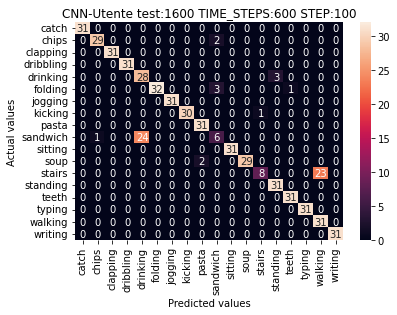

Utente test:  1602
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.1634 - accuracy: 0.2840 - f1_m: 0.1552 - val_loss: 1.6187 - val_accuracy: 0.4866 - val_f1_m: 0.2723
Epoch 2/100
199/199 [==============================] - 6s 33ms/step - loss: 1.5337 - accuracy: 0.4795 - f1_m: 0.3861 - val_loss: 1.2556 - val_accuracy: 0.5821 - val_f1_m: 0.4953
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.3197 - accuracy: 0.5473 - f1_m: 0.4867 - val_loss: 1.1031 - val_accuracy: 0.6233 - val_f1_m: 0.5610
Epoch 4/100
199/199 [==============================] - 7s 33ms/step - loss: 1.1822 - accuracy: 0.5920 - f1_m: 0.5442 - val_loss: 0.9707 - val_accuracy: 0.6710 - val_f1_m: 0.6202
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.0980 - accuracy: 0.6143 - f1_m: 0.5762 - val_loss: 0.9116 - val_accuracy: 0.676

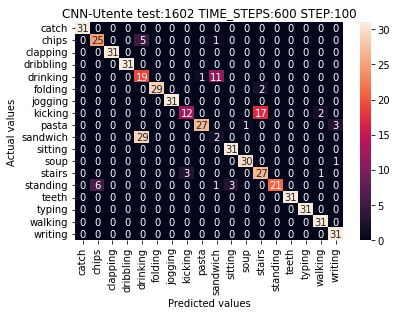

Utente test:  1604
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 7s 34ms/step - loss: 2.0829 - accuracy: 0.3188 - f1_m: 0.1893 - val_loss: 1.5652 - val_accuracy: 0.4795 - val_f1_m: 0.3530
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.4620 - accuracy: 0.5033 - f1_m: 0.4197 - val_loss: 1.2150 - val_accuracy: 0.5889 - val_f1_m: 0.4982
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2127 - accuracy: 0.5836 - f1_m: 0.5262 - val_loss: 1.0366 - val_accuracy: 0.6398 - val_f1_m: 0.6100
Epoch 4/100
199/199 [==============================] - 7s 33ms/step - loss: 1.0909 - accuracy: 0.6190 - f1_m: 0.5787 - val_loss: 0.9502 - val_accuracy: 0.6733 - val_f1_m: 0.6430
Epoch 5/100
199/199 [==============================] - 6s 32ms/step - loss: 1.0073 - accuracy: 0.6458 - f1_m: 0.6115 - val_loss: 0.9195 - val_accuracy: 0.679

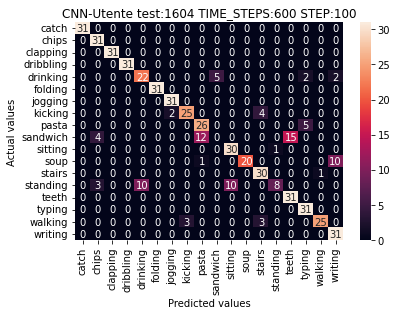

Utente test:  1605
Training: x-> 25431 y-> 25431
Validation: x-> 6358 y-> 6358
Testing: x-> 571 y-> 571
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.1486 - accuracy: 0.2944 - f1_m: 0.1659 - val_loss: 1.7091 - val_accuracy: 0.4335 - val_f1_m: 0.3084
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.5270 - accuracy: 0.4848 - f1_m: 0.3910 - val_loss: 1.2594 - val_accuracy: 0.5843 - val_f1_m: 0.4830
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2817 - accuracy: 0.5589 - f1_m: 0.4960 - val_loss: 1.1169 - val_accuracy: 0.6112 - val_f1_m: 0.5706
Epoch 4/100
199/199 [==============================] - 7s 33ms/step - loss: 1.1733 - accuracy: 0.5905 - f1_m: 0.5460 - val_loss: 1.0296 - val_accuracy: 0.6447 - val_f1_m: 0.5979
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.0774 - accuracy: 0.6236 - f1_m: 0.5873 - val_loss: 1.0043 - val_accuracy: 0.653

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


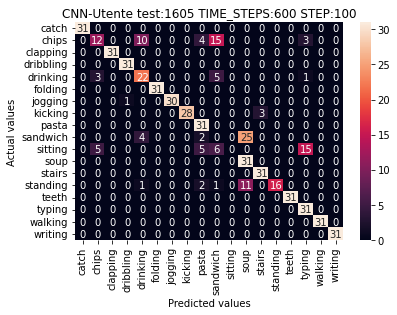

Utente test:  1606
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 7s 34ms/step - loss: 2.0683 - accuracy: 0.3164 - f1_m: 0.1966 - val_loss: 1.4769 - val_accuracy: 0.5273 - val_f1_m: 0.3716
Epoch 2/100
199/199 [==============================] - 6s 33ms/step - loss: 1.4618 - accuracy: 0.5037 - f1_m: 0.4218 - val_loss: 1.1609 - val_accuracy: 0.6060 - val_f1_m: 0.5233
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.2356 - accuracy: 0.5755 - f1_m: 0.5103 - val_loss: 1.0568 - val_accuracy: 0.6241 - val_f1_m: 0.5791
Epoch 4/100
199/199 [==============================] - 7s 33ms/step - loss: 1.0864 - accuracy: 0.6187 - f1_m: 0.5728 - val_loss: 0.9365 - val_accuracy: 0.6730 - val_f1_m: 0.6417
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.0015 - accuracy: 0.6462 - f1_m: 0.6102 - val_loss: 0.8235 - val_accuracy: 0.713

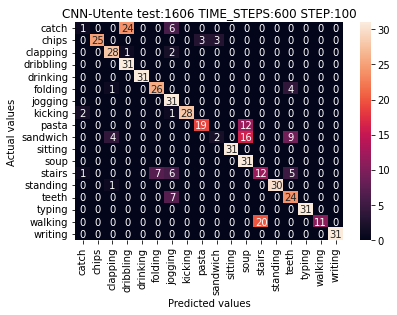

Utente test:  1610
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 7s 35ms/step - loss: 2.0835 - accuracy: 0.3114 - f1_m: 0.1777 - val_loss: 1.7292 - val_accuracy: 0.4289 - val_f1_m: 0.3048
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.4722 - accuracy: 0.4999 - f1_m: 0.4081 - val_loss: 1.2753 - val_accuracy: 0.5713 - val_f1_m: 0.4674
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2465 - accuracy: 0.5726 - f1_m: 0.5136 - val_loss: 1.0653 - val_accuracy: 0.6414 - val_f1_m: 0.5558
Epoch 4/100
199/199 [==============================] - 7s 33ms/step - loss: 1.1135 - accuracy: 0.6179 - f1_m: 0.5711 - val_loss: 0.9391 - val_accuracy: 0.6859 - val_f1_m: 0.6470
Epoch 5/100
199/199 [==============================] - 7s 33ms/step - loss: 1.0201 - accuracy: 0.6444 - f1_m: 0.6082 - val_loss: 0.9000 - val_accuracy: 0.684

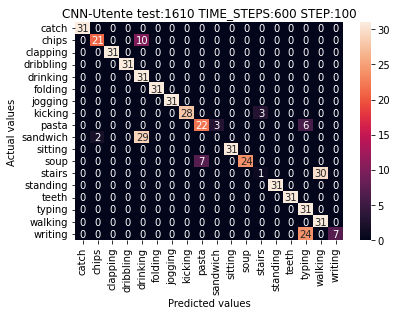

Utente test:  1611
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 7s 35ms/step - loss: 2.1029 - accuracy: 0.3070 - f1_m: 0.1735 - val_loss: 1.5765 - val_accuracy: 0.4859 - val_f1_m: 0.3353
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.5000 - accuracy: 0.4926 - f1_m: 0.4046 - val_loss: 1.2360 - val_accuracy: 0.5829 - val_f1_m: 0.5038
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2754 - accuracy: 0.5624 - f1_m: 0.5027 - val_loss: 1.0561 - val_accuracy: 0.6301 - val_f1_m: 0.5995
Epoch 4/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1404 - accuracy: 0.6054 - f1_m: 0.5623 - val_loss: 0.9554 - val_accuracy: 0.6702 - val_f1_m: 0.6407
Epoch 5/100
199/199 [==============================] - 7s 33ms/step - loss: 1.0482 - accuracy: 0.6322 - f1_m: 0.5983 - val_loss: 0.9041 - val_accuracy: 0.693

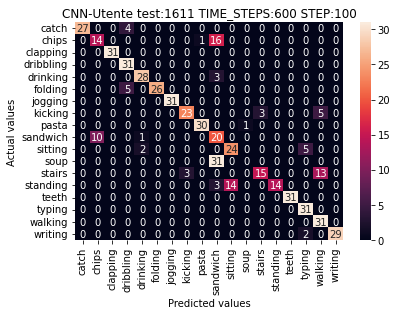

Utente test:  1614
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.0774 - accuracy: 0.3124 - f1_m: 0.1823 - val_loss: 1.6704 - val_accuracy: 0.4510 - val_f1_m: 0.2969
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.4866 - accuracy: 0.5019 - f1_m: 0.4108 - val_loss: 1.2307 - val_accuracy: 0.5766 - val_f1_m: 0.5087
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2842 - accuracy: 0.5578 - f1_m: 0.4989 - val_loss: 1.1525 - val_accuracy: 0.5843 - val_f1_m: 0.5559
Epoch 4/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1624 - accuracy: 0.5969 - f1_m: 0.5524 - val_loss: 1.0285 - val_accuracy: 0.6315 - val_f1_m: 0.6053
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.0582 - accuracy: 0.6329 - f1_m: 0.5989 - val_loss: 0.9529 - val_accuracy: 0.673

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


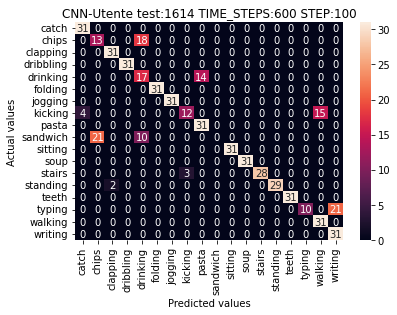

Utente test:  1615
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 7s 35ms/step - loss: 2.0731 - accuracy: 0.3172 - f1_m: 0.1822 - val_loss: 1.6709 - val_accuracy: 0.4551 - val_f1_m: 0.2880
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.4794 - accuracy: 0.5017 - f1_m: 0.4112 - val_loss: 1.3962 - val_accuracy: 0.5375 - val_f1_m: 0.4211
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2625 - accuracy: 0.5672 - f1_m: 0.5097 - val_loss: 1.1019 - val_accuracy: 0.6139 - val_f1_m: 0.5680
Epoch 4/100
199/199 [==============================] - 7s 33ms/step - loss: 1.1398 - accuracy: 0.6048 - f1_m: 0.5627 - val_loss: 1.0425 - val_accuracy: 0.6307 - val_f1_m: 0.6014
Epoch 5/100
199/199 [==============================] - 7s 33ms/step - loss: 1.0457 - accuracy: 0.6359 - f1_m: 0.6046 - val_loss: 0.9889 - val_accuracy: 0.643

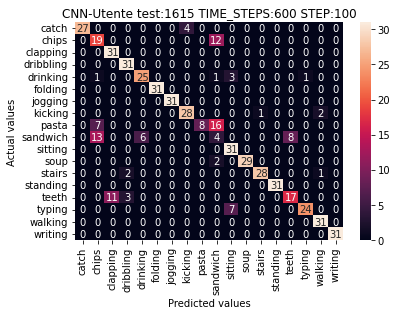

Utente test:  1616
Training: x-> 25466 y-> 25466
Validation: x-> 6367 y-> 6367
Testing: x-> 527 y-> 527
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1482 - accuracy: 0.2929 - f1_m: 0.1668 - val_loss: 1.5946 - val_accuracy: 0.4679 - val_f1_m: 0.3394
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.5358 - accuracy: 0.4755 - f1_m: 0.3900 - val_loss: 1.2734 - val_accuracy: 0.5690 - val_f1_m: 0.4597
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2954 - accuracy: 0.5511 - f1_m: 0.4843 - val_loss: 1.1108 - val_accuracy: 0.6304 - val_f1_m: 0.5223
Epoch 4/100
199/199 [==============================] - 7s 33ms/step - loss: 1.1601 - accuracy: 0.5940 - f1_m: 0.5448 - val_loss: 1.0129 - val_accuracy: 0.6537 - val_f1_m: 0.5997
Epoch 5/100
199/199 [==============================] - 7s 33ms/step - loss: 1.0642 - accuracy: 0.6224 - f1_m: 0.5834 - val_loss: 0.9271 - val_accuracy: 0.679

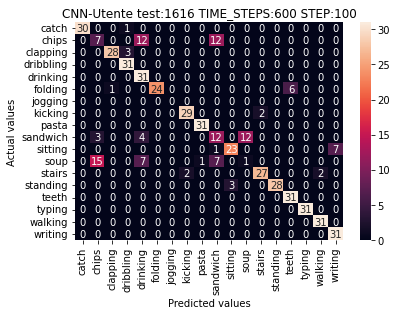

Utente test:  1619
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.0899 - accuracy: 0.3123 - f1_m: 0.1844 - val_loss: 1.5444 - val_accuracy: 0.4872 - val_f1_m: 0.3618
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.4889 - accuracy: 0.4971 - f1_m: 0.4186 - val_loss: 1.2493 - val_accuracy: 0.5845 - val_f1_m: 0.4969
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2758 - accuracy: 0.5634 - f1_m: 0.5032 - val_loss: 1.1046 - val_accuracy: 0.6216 - val_f1_m: 0.5800
Epoch 4/100
199/199 [==============================] - 7s 33ms/step - loss: 1.1317 - accuracy: 0.6100 - f1_m: 0.5636 - val_loss: 0.9872 - val_accuracy: 0.6686 - val_f1_m: 0.6253
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.0336 - accuracy: 0.6359 - f1_m: 0.6070 - val_loss: 0.9424 - val_accuracy: 0.688

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


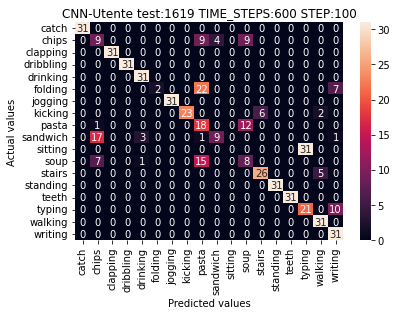

Utente test:  1623
Training: x-> 25442 y-> 25442
Validation: x-> 6361 y-> 6361
Testing: x-> 557 y-> 557
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1599 - accuracy: 0.2904 - f1_m: 0.1537 - val_loss: 1.6615 - val_accuracy: 0.4608 - val_f1_m: 0.3039
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.5284 - accuracy: 0.4806 - f1_m: 0.3878 - val_loss: 1.2575 - val_accuracy: 0.5623 - val_f1_m: 0.4854
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2755 - accuracy: 0.5625 - f1_m: 0.5013 - val_loss: 1.0974 - val_accuracy: 0.6202 - val_f1_m: 0.5697
Epoch 4/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1306 - accuracy: 0.6079 - f1_m: 0.5611 - val_loss: 0.9858 - val_accuracy: 0.6460 - val_f1_m: 0.6170
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.0276 - accuracy: 0.6417 - f1_m: 0.6066 - val_loss: 0.8987 - val_accuracy: 0.689

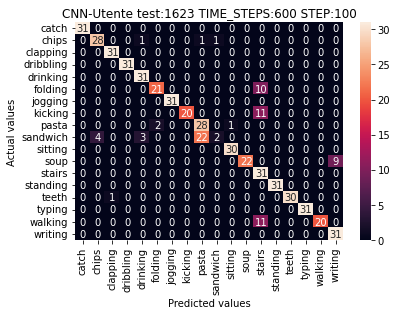

Utente test:  1625
Training: x-> 25427 y-> 25427
Validation: x-> 6357 y-> 6357
Testing: x-> 576 y-> 576
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1763 - accuracy: 0.2791 - f1_m: 0.1536 - val_loss: 1.6987 - val_accuracy: 0.4340 - val_f1_m: 0.3114
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.5750 - accuracy: 0.4682 - f1_m: 0.3751 - val_loss: 1.3246 - val_accuracy: 0.5352 - val_f1_m: 0.4755
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.3473 - accuracy: 0.5357 - f1_m: 0.4716 - val_loss: 1.1826 - val_accuracy: 0.5962 - val_f1_m: 0.5220
Epoch 4/100
199/199 [==============================] - 7s 34ms/step - loss: 1.2315 - accuracy: 0.5709 - f1_m: 0.5144 - val_loss: 1.1116 - val_accuracy: 0.6148 - val_f1_m: 0.6003
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1278 - accuracy: 0.6051 - f1_m: 0.5620 - val_loss: 0.9820 - val_accuracy: 0.655

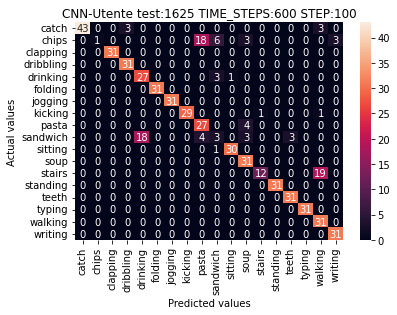

Utente test:  1626
Training: x-> 25422 y-> 25422
Validation: x-> 6356 y-> 6356
Testing: x-> 582 y-> 582
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1970 - accuracy: 0.2792 - f1_m: 0.1415 - val_loss: 1.5893 - val_accuracy: 0.4808 - val_f1_m: 0.3122
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.5779 - accuracy: 0.4704 - f1_m: 0.3689 - val_loss: 1.3714 - val_accuracy: 0.5489 - val_f1_m: 0.4318
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.3380 - accuracy: 0.5415 - f1_m: 0.4707 - val_loss: 1.1665 - val_accuracy: 0.6010 - val_f1_m: 0.5319
Epoch 4/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2191 - accuracy: 0.5711 - f1_m: 0.5193 - val_loss: 1.0747 - val_accuracy: 0.6273 - val_f1_m: 0.5746
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1271 - accuracy: 0.6043 - f1_m: 0.5616 - val_loss: 0.9866 - val_accuracy: 0.664

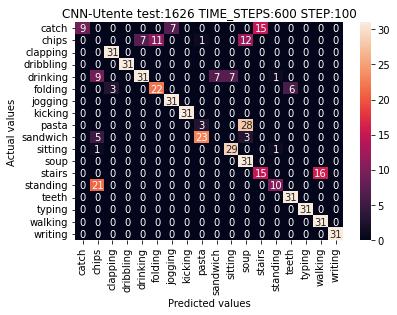

Utente test:  1627
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.1180 - accuracy: 0.3008 - f1_m: 0.1684 - val_loss: 1.5497 - val_accuracy: 0.4690 - val_f1_m: 0.3518
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.4642 - accuracy: 0.4990 - f1_m: 0.4114 - val_loss: 1.1888 - val_accuracy: 0.5829 - val_f1_m: 0.5473
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.2295 - accuracy: 0.5754 - f1_m: 0.5151 - val_loss: 1.0874 - val_accuracy: 0.6343 - val_f1_m: 0.5889
Epoch 4/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1098 - accuracy: 0.6105 - f1_m: 0.5679 - val_loss: 1.0330 - val_accuracy: 0.6383 - val_f1_m: 0.6140
Epoch 5/100
199/199 [==============================] - 7s 35ms/step - loss: 1.0182 - accuracy: 0.6400 - f1_m: 0.6046 - val_loss: 0.9148 - val_accuracy: 0.668

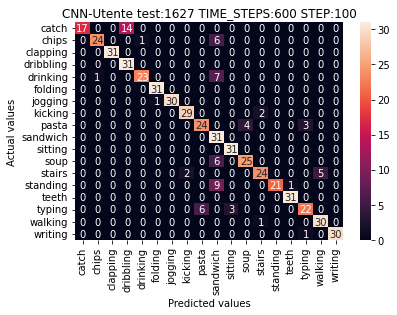

Utente test:  1630
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1127 - accuracy: 0.3096 - f1_m: 0.1787 - val_loss: 1.6477 - val_accuracy: 0.4579 - val_f1_m: 0.3339
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.4975 - accuracy: 0.4953 - f1_m: 0.4016 - val_loss: 1.2485 - val_accuracy: 0.5587 - val_f1_m: 0.5035
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.2776 - accuracy: 0.5612 - f1_m: 0.4972 - val_loss: 1.1291 - val_accuracy: 0.6010 - val_f1_m: 0.5631
Epoch 4/100
199/199 [==============================] - 7s 33ms/step - loss: 1.1434 - accuracy: 0.5986 - f1_m: 0.5519 - val_loss: 0.9893 - val_accuracy: 0.6502 - val_f1_m: 0.6152
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.0674 - accuracy: 0.6237 - f1_m: 0.5884 - val_loss: 0.9570 - val_accuracy: 0.671

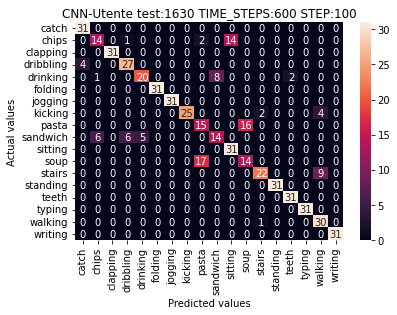

Utente test:  1631
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1157 - accuracy: 0.3065 - f1_m: 0.1772 - val_loss: 1.6705 - val_accuracy: 0.4642 - val_f1_m: 0.2964
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.5057 - accuracy: 0.4926 - f1_m: 0.4003 - val_loss: 1.3153 - val_accuracy: 0.5628 - val_f1_m: 0.4453
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.3044 - accuracy: 0.5525 - f1_m: 0.4869 - val_loss: 1.1738 - val_accuracy: 0.5968 - val_f1_m: 0.5505
Epoch 4/100
199/199 [==============================] - 7s 33ms/step - loss: 1.1641 - accuracy: 0.5956 - f1_m: 0.5549 - val_loss: 1.0566 - val_accuracy: 0.6280 - val_f1_m: 0.5899
Epoch 5/100
199/199 [==============================] - 7s 33ms/step - loss: 1.0821 - accuracy: 0.6234 - f1_m: 0.5848 - val_loss: 0.9875 - val_accuracy: 0.662

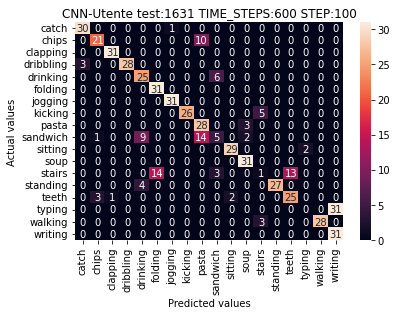

Utente test:  1632
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1871 - accuracy: 0.2810 - f1_m: 0.1473 - val_loss: 1.6854 - val_accuracy: 0.4468 - val_f1_m: 0.3043
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.5535 - accuracy: 0.4766 - f1_m: 0.3832 - val_loss: 1.3986 - val_accuracy: 0.5347 - val_f1_m: 0.4392
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.3435 - accuracy: 0.5445 - f1_m: 0.4767 - val_loss: 1.1994 - val_accuracy: 0.5897 - val_f1_m: 0.5281
Epoch 4/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2233 - accuracy: 0.5789 - f1_m: 0.5201 - val_loss: 1.0708 - val_accuracy: 0.6463 - val_f1_m: 0.5939
Epoch 5/100
199/199 [==============================] - 7s 33ms/step - loss: 1.1421 - accuracy: 0.6027 - f1_m: 0.5598 - val_loss: 1.0036 - val_accuracy: 0.661

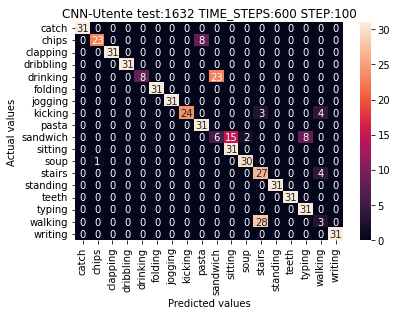

Utente test:  1634
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.1471 - accuracy: 0.2949 - f1_m: 0.1609 - val_loss: 1.6039 - val_accuracy: 0.4561 - val_f1_m: 0.3143
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.5114 - accuracy: 0.4890 - f1_m: 0.3940 - val_loss: 1.2427 - val_accuracy: 0.5727 - val_f1_m: 0.4768
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2763 - accuracy: 0.5609 - f1_m: 0.4954 - val_loss: 1.0875 - val_accuracy: 0.6078 - val_f1_m: 0.5463
Epoch 4/100
199/199 [==============================] - 7s 33ms/step - loss: 1.1290 - accuracy: 0.6081 - f1_m: 0.5597 - val_loss: 0.9561 - val_accuracy: 0.6592 - val_f1_m: 0.6238
Epoch 5/100
199/199 [==============================] - 7s 33ms/step - loss: 1.0385 - accuracy: 0.6378 - f1_m: 0.6018 - val_loss: 0.8757 - val_accuracy: 0.690

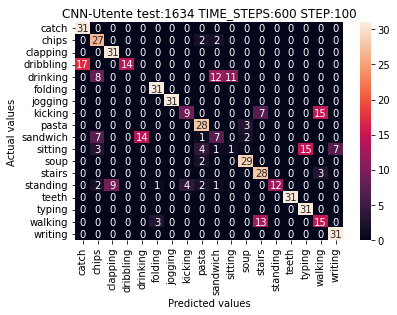

Utente test:  1635
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 7s 34ms/step - loss: 2.1400 - accuracy: 0.2970 - f1_m: 0.1620 - val_loss: 1.8300 - val_accuracy: 0.3922 - val_f1_m: 0.2742
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.5372 - accuracy: 0.4780 - f1_m: 0.3814 - val_loss: 1.3813 - val_accuracy: 0.5246 - val_f1_m: 0.4640
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.3041 - accuracy: 0.5527 - f1_m: 0.4852 - val_loss: 1.1562 - val_accuracy: 0.6065 - val_f1_m: 0.5412
Epoch 4/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1768 - accuracy: 0.5915 - f1_m: 0.5365 - val_loss: 1.0575 - val_accuracy: 0.6403 - val_f1_m: 0.5915
Epoch 5/100
199/199 [==============================] - 7s 33ms/step - loss: 1.0949 - accuracy: 0.6192 - f1_m: 0.5751 - val_loss: 0.9905 - val_accuracy: 0.654

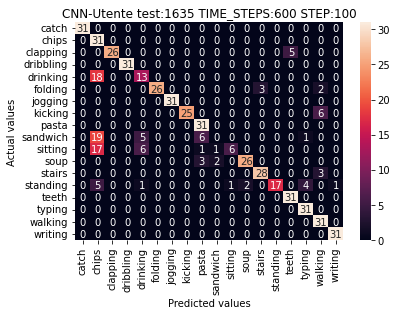

Utente test:  1641
Training: x-> 25455 y-> 25455
Validation: x-> 6364 y-> 6364
Testing: x-> 541 y-> 541
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 37ms/step - loss: 2.1987 - accuracy: 0.2825 - f1_m: 0.1485 - val_loss: 1.6839 - val_accuracy: 0.4197 - val_f1_m: 0.2798
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.6138 - accuracy: 0.4555 - f1_m: 0.3571 - val_loss: 1.3649 - val_accuracy: 0.5294 - val_f1_m: 0.4326
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.3871 - accuracy: 0.5258 - f1_m: 0.4493 - val_loss: 1.1676 - val_accuracy: 0.5984 - val_f1_m: 0.5270
Epoch 4/100
199/199 [==============================] - 7s 35ms/step - loss: 1.2380 - accuracy: 0.5738 - f1_m: 0.5210 - val_loss: 1.0753 - val_accuracy: 0.6182 - val_f1_m: 0.5675
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1449 - accuracy: 0.6052 - f1_m: 0.5582 - val_loss: 0.9976 - val_accuracy: 0.645

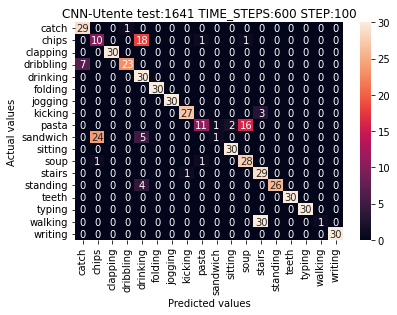

Utente test:  1643
Training: x-> 25454 y-> 25454
Validation: x-> 6364 y-> 6364
Testing: x-> 542 y-> 542
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1387 - accuracy: 0.3000 - f1_m: 0.1689 - val_loss: 1.7276 - val_accuracy: 0.4585 - val_f1_m: 0.3063
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.5319 - accuracy: 0.4860 - f1_m: 0.4008 - val_loss: 1.3399 - val_accuracy: 0.5522 - val_f1_m: 0.4833
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.3108 - accuracy: 0.5525 - f1_m: 0.4884 - val_loss: 1.1485 - val_accuracy: 0.6124 - val_f1_m: 0.5552
Epoch 4/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1754 - accuracy: 0.5961 - f1_m: 0.5473 - val_loss: 1.0336 - val_accuracy: 0.6408 - val_f1_m: 0.6014
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.0941 - accuracy: 0.6161 - f1_m: 0.5783 - val_loss: 0.9819 - val_accuracy: 0.667

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


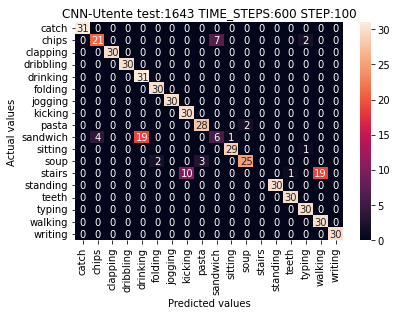

Utente test:  1645
Training: x-> 25430 y-> 25430
Validation: x-> 6358 y-> 6358
Testing: x-> 572 y-> 572
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 37ms/step - loss: 2.0889 - accuracy: 0.3105 - f1_m: 0.1827 - val_loss: 1.5302 - val_accuracy: 0.4998 - val_f1_m: 0.3489
Epoch 2/100
199/199 [==============================] - 7s 35ms/step - loss: 1.4678 - accuracy: 0.5019 - f1_m: 0.4156 - val_loss: 1.2439 - val_accuracy: 0.5648 - val_f1_m: 0.4789
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.2344 - accuracy: 0.5736 - f1_m: 0.5174 - val_loss: 1.0334 - val_accuracy: 0.6466 - val_f1_m: 0.5958
Epoch 4/100
199/199 [==============================] - 7s 35ms/step - loss: 1.0957 - accuracy: 0.6160 - f1_m: 0.5762 - val_loss: 0.9680 - val_accuracy: 0.6567 - val_f1_m: 0.6315
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 0.9933 - accuracy: 0.6483 - f1_m: 0.6200 - val_loss: 0.8946 - val_accuracy: 0.688

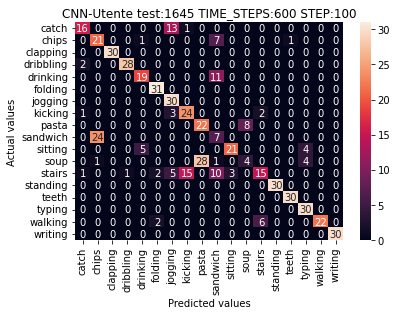

Utente test:  1646
Training: x-> 25455 y-> 25455
Validation: x-> 6364 y-> 6364
Testing: x-> 541 y-> 541
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.1207 - accuracy: 0.2992 - f1_m: 0.1756 - val_loss: 1.6118 - val_accuracy: 0.4665 - val_f1_m: 0.3084
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.5386 - accuracy: 0.4736 - f1_m: 0.3812 - val_loss: 1.3501 - val_accuracy: 0.5599 - val_f1_m: 0.4325
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.3225 - accuracy: 0.5459 - f1_m: 0.4755 - val_loss: 1.1266 - val_accuracy: 0.6020 - val_f1_m: 0.5392
Epoch 4/100
199/199 [==============================] - 7s 35ms/step - loss: 1.1883 - accuracy: 0.5810 - f1_m: 0.5295 - val_loss: 1.0998 - val_accuracy: 0.6185 - val_f1_m: 0.5899
Epoch 5/100
199/199 [==============================] - 7s 35ms/step - loss: 1.0974 - accuracy: 0.6132 - f1_m: 0.5670 - val_loss: 0.9628 - val_accuracy: 0.660

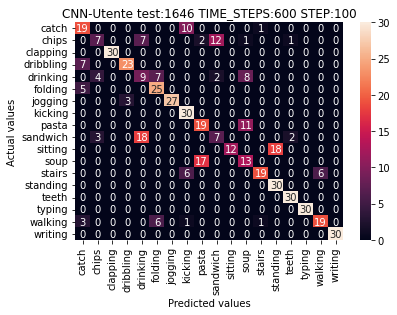

Utente test:  1647
Training: x-> 25436 y-> 25436
Validation: x-> 6360 y-> 6360
Testing: x-> 564 y-> 564
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1020 - accuracy: 0.3137 - f1_m: 0.1868 - val_loss: 1.6223 - val_accuracy: 0.4712 - val_f1_m: 0.3128
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.4743 - accuracy: 0.5007 - f1_m: 0.4175 - val_loss: 1.2232 - val_accuracy: 0.5841 - val_f1_m: 0.5146
Epoch 3/100
199/199 [==============================] - 7s 35ms/step - loss: 1.2482 - accuracy: 0.5745 - f1_m: 0.5158 - val_loss: 1.0746 - val_accuracy: 0.6374 - val_f1_m: 0.5739
Epoch 4/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1036 - accuracy: 0.6181 - f1_m: 0.5759 - val_loss: 0.9706 - val_accuracy: 0.6621 - val_f1_m: 0.6258
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.0169 - accuracy: 0.6468 - f1_m: 0.6142 - val_loss: 0.9296 - val_accuracy: 0.668

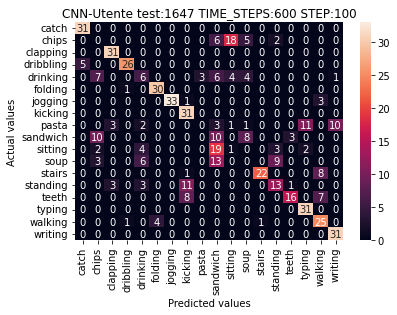

Utente test:  1649
Training: x-> 25440 y-> 25440
Validation: x-> 6360 y-> 6360
Testing: x-> 560 y-> 560
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1537 - accuracy: 0.2879 - f1_m: 0.1659 - val_loss: 1.5737 - val_accuracy: 0.4827 - val_f1_m: 0.3357
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.5454 - accuracy: 0.4796 - f1_m: 0.3878 - val_loss: 1.2785 - val_accuracy: 0.5546 - val_f1_m: 0.4925
Epoch 3/100
199/199 [==============================] - 7s 35ms/step - loss: 1.3374 - accuracy: 0.5426 - f1_m: 0.4748 - val_loss: 1.1965 - val_accuracy: 0.6028 - val_f1_m: 0.5265
Epoch 4/100
199/199 [==============================] - 7s 34ms/step - loss: 1.2097 - accuracy: 0.5825 - f1_m: 0.5257 - val_loss: 1.0844 - val_accuracy: 0.6165 - val_f1_m: 0.5834
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1225 - accuracy: 0.6074 - f1_m: 0.5600 - val_loss: 1.0021 - val_accuracy: 0.658

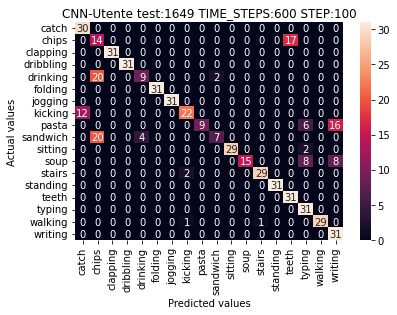

Accuracy media: 0.7867197041380398
F1 weighted media: 0.7657880907004545
F1 macro media: 0.7666431895873218
   Time Steps  Step  Average accuracy  Average F1 Weighted  Average F1 Macro  \
0         600   100           0.78672             0.765788          0.766643   

                                             reports  \
0  [              precision    recall  f1-score  ...   

                                    confusion_matrix  
0  [AxesSubplot(0.125,0.125;0.62x0.755), AxesSubp...  


In [ ]:
import itertools
import gc
from tabnanny import verbose
from tkinter import Y
batchsize=128

if leave_one_subject_out:
    cnn_results_dict = []
    cnn_results = pd.DataFrame()
    try:
        mkdir(cnn_dir + leave_one_subject_out_dir)
        mkdir(cnn_dir + leave_one_subject_out_dir + plot_dir)
    except OSError as error:
        print(error)

    for config in itertools.product(time_steps_list, step_list):

        time_step = config[0]
        step=config[1]

        cnn_f1_macro = []
        cnn_f1_weighted = []
        cnn_acc = []
        cnn_class_reports = []
        cnn_confusion_matrixes = []

        print(time_step,step)

        for user_id in users_ids:
            if user_id not in notConsider:

              print("Utente test: ", user_id)

              X_test = np.array(data_cnn[time_step][step][user_id][0])
              y_test = np.array(data_cnn[time_step][step][user_id][1])

              X_train = []
              y_train = []

              for id in users_ids:
                  if not id == user_id:
                      X_train += data_cnn[time_step][step][id][0]
                      y_train += data_cnn[time_step][step][id][1]
            
              X_train = np.array(X_train)
              y_train = np.array(y_train)

              scaler = RobustScaler()
              X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
              X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

              y_train = enc.transform(y_train)
              y_test = enc.transform(y_test)

              X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
              X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

      #      print(X_train)
       #     print(y_train)
        #    print(X_test)

         #   print(y_test)

              model = createCNN(X_train[0].shape, y_train[0].shape[0])

              callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

              XTraining, XValidation, YTraining, YValidation = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

              print("Training: x->",len(XTraining),"y->",len(YTraining))
              print("Validation: x->",len(XValidation),"y->",len(YValidation))
              print("Testing: x->",len(X_test),"y->",len(y_test))
              print("Total: x->",len(XTraining)+len(XValidation)+len(X_test),"y->",len(YTraining)+len(YValidation)+len(y_test))

              model.fit(XTraining, YTraining, batch_size = batchsize, epochs = 100, validation_data=(XValidation,YValidation), verbose=1, callbacks=[callback], shuffle=True, workers=10, use_multiprocessing=True )

              rounded_labels=np.argmax(y_test, axis=1)
              y_pred = np.argmax(model.predict(X_test), axis=-1)

              cnn_acc.append(accuracy_score(rounded_labels, y_pred))
              cnn_f1_weighted.append(f1_score(rounded_labels, y_pred, average='weighted'))
              cnn_f1_macro.append(f1_score(rounded_labels, y_pred, average='macro'))
            #cnn_f1.append(f1_m(rounded_labels,y_pred))

              class_report = classification_report(rounded_labels, y_pred, digits=4)
              print(class_report)
              cnn_class_reports.append(class_report)
            
              conf_matrix = confusion_matrix(rounded_labels, y_pred, labels=range(0,len(enc.categories_[0])))

              ax = seaborn.heatmap(conf_matrix, annot=True, fmt='d')

              ax.set_title("CNN-Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))

              ax.set_xlabel('Predicted values')
              ax.set_ylabel('Actual values')

              ax.xaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=90)
              ax.yaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=0)

              ax.get_figure().savefig(cnn_dir + leave_one_subject_out_dir + plot_dir +'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
            #model_history_file=open(cnn_dir+'/'+ax.get_title().replace(":"," ")+".txt", "w")
            #model_history_file.write(model.history())
            #model_history_file.close()

              cnn_confusion_matrixes.append(ax)
              plt.show()

              gc.collect()            

        print("Accuracy media:",np.mean(cnn_acc))
        print("F1 weighted media:",np.mean(cnn_f1_weighted))
        print("F1 macro media:",np.mean(cnn_f1_macro))

        cnn_results_dict.append({
            'Time Steps':time_step,
            'Step':step,
            'Average accuracy':np.mean(cnn_acc),
            'Average F1 Weighted': np.mean(cnn_f1_weighted),
            'Average F1 Macro': np.mean(cnn_f1_macro),
            'reports':cnn_class_reports,
            'confusion_matrix':cnn_confusion_matrixes
        })
        
        cnn_results = pd.DataFrame(cnn_results_dict)
        print(cnn_results)
        cnn_results.to_csv(cnn_dir + leave_one_subject_out_dir + result_filename)


[Errno 17] File exists: '2022-12-05T10_02_03\\cnn\\leave_one_subject_out'
600 100
Utente test:  1600
Training: x-> 25437 y-> 25437
Validation: x-> 6360 y-> 6360
Testing: x-> 563 y-> 563
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 16s 34ms/step - loss: 2.1736 - accuracy: 0.2884 - f1_m: 0.1493 - val_loss: 1.6833 - val_accuracy: 0.4500 - val_f1_m: 0.2756
Epoch 2/100
199/199 [==============================] - 6s 33ms/step - loss: 1.5559 - accuracy: 0.4720 - f1_m: 0.3723 - val_loss: 1.3349 - val_accuracy: 0.5410 - val_f1_m: 0.4569
Epoch 3/100
199/199 [==============================] - 6s 31ms/step - loss: 1.3183 - accuracy: 0.5500 - f1_m: 0.4797 - val_loss: 1.1392 - val_accuracy: 0.6097 - val_f1_m: 0.5529
Epoch 4/100
199/199 [==============================] - 6s 31ms/step - loss: 1.1843 - accuracy: 0.5911 - f1_m: 0.5421 - val_loss: 1.0629 - val_accuracy: 0.6252 - val_f1_m: 0.5861
Epoch 5/100
199/199 [==============================] - 6s 31ms/step - loss

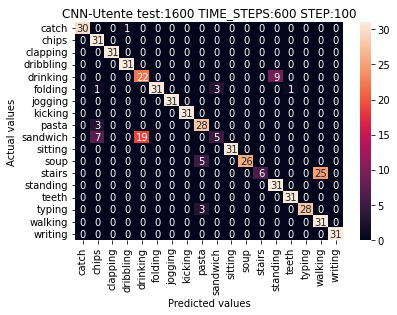

Utente test:  1601
Training: x-> 25443 y-> 25443
Validation: x-> 6361 y-> 6361
Testing: x-> 556 y-> 556
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.1511 - accuracy: 0.2899 - f1_m: 0.1615 - val_loss: 1.5929 - val_accuracy: 0.4908 - val_f1_m: 0.3505
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.5055 - accuracy: 0.4937 - f1_m: 0.3974 - val_loss: 1.2551 - val_accuracy: 0.5806 - val_f1_m: 0.4794
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2632 - accuracy: 0.5665 - f1_m: 0.5011 - val_loss: 1.0515 - val_accuracy: 0.6299 - val_f1_m: 0.5710
Epoch 4/100
199/199 [==============================] - 6s 32ms/step - loss: 1.1378 - accuracy: 0.6049 - f1_m: 0.5558 - val_loss: 0.9560 - val_accuracy: 0.6629 - val_f1_m: 0.6210
Epoch 5/100
199/199 [==============================] - 6s 32ms/step - loss: 1.0447 - accuracy: 0.6337 - f1_m: 0.5964 - val_loss: 0.8628 - val_accuracy: 0.704

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


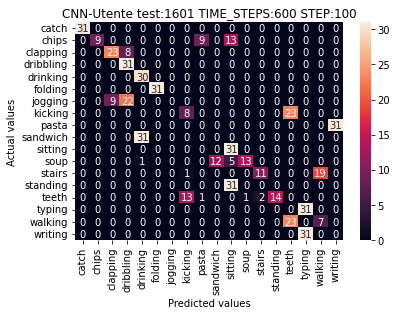

Utente test:  1602
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.1016 - accuracy: 0.3118 - f1_m: 0.1807 - val_loss: 1.5913 - val_accuracy: 0.4833 - val_f1_m: 0.3386
Epoch 2/100
199/199 [==============================] - 6s 32ms/step - loss: 1.4689 - accuracy: 0.4963 - f1_m: 0.4133 - val_loss: 1.1863 - val_accuracy: 0.5986 - val_f1_m: 0.5174
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.2224 - accuracy: 0.5757 - f1_m: 0.5212 - val_loss: 1.0173 - val_accuracy: 0.6406 - val_f1_m: 0.6185
Epoch 4/100
199/199 [==============================] - 6s 32ms/step - loss: 1.1120 - accuracy: 0.6119 - f1_m: 0.5709 - val_loss: 0.9250 - val_accuracy: 0.6905 - val_f1_m: 0.6623
Epoch 5/100
199/199 [==============================] - 6s 32ms/step - loss: 1.0212 - accuracy: 0.6412 - f1_m: 0.6063 - val_loss: 0.9616 - val_accuracy: 0.676

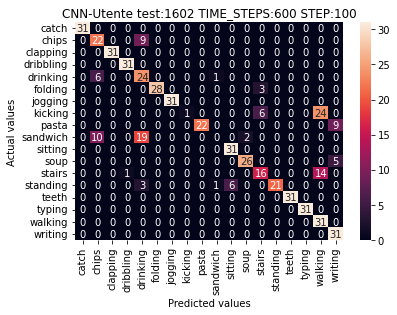

Utente test:  1603
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 7s 35ms/step - loss: 2.1118 - accuracy: 0.3102 - f1_m: 0.1705 - val_loss: 1.5978 - val_accuracy: 0.4543 - val_f1_m: 0.3328
Epoch 2/100
199/199 [==============================] - 6s 32ms/step - loss: 1.4778 - accuracy: 0.4983 - f1_m: 0.4156 - val_loss: 1.2876 - val_accuracy: 0.5314 - val_f1_m: 0.4979
Epoch 3/100
199/199 [==============================] - 6s 32ms/step - loss: 1.2628 - accuracy: 0.5677 - f1_m: 0.5091 - val_loss: 1.2066 - val_accuracy: 0.5818 - val_f1_m: 0.5156
Epoch 4/100
199/199 [==============================] - 6s 32ms/step - loss: 1.1517 - accuracy: 0.6017 - f1_m: 0.5550 - val_loss: 1.0465 - val_accuracy: 0.6258 - val_f1_m: 0.5966
Epoch 5/100
199/199 [==============================] - 6s 32ms/step - loss: 1.0707 - accuracy: 0.6269 - f1_m: 0.5931 - val_loss: 0.9971 - val_accuracy: 0.646

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


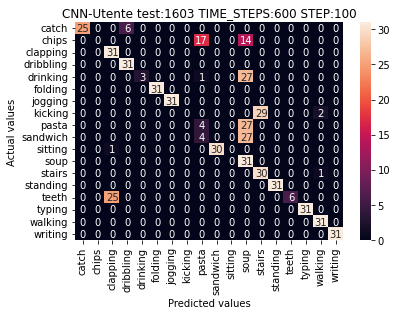

Utente test:  1604
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.1079 - accuracy: 0.3027 - f1_m: 0.1765 - val_loss: 1.4931 - val_accuracy: 0.5186 - val_f1_m: 0.3853
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.4591 - accuracy: 0.5054 - f1_m: 0.4223 - val_loss: 1.2226 - val_accuracy: 0.5744 - val_f1_m: 0.5358
Epoch 3/100
199/199 [==============================] - 6s 33ms/step - loss: 1.2342 - accuracy: 0.5755 - f1_m: 0.5127 - val_loss: 1.0683 - val_accuracy: 0.6246 - val_f1_m: 0.5956
Epoch 4/100
199/199 [==============================] - 6s 33ms/step - loss: 1.0911 - accuracy: 0.6193 - f1_m: 0.5751 - val_loss: 0.9766 - val_accuracy: 0.6546 - val_f1_m: 0.6186
Epoch 5/100
199/199 [==============================] - 7s 33ms/step - loss: 1.0178 - accuracy: 0.6442 - f1_m: 0.6068 - val_loss: 0.8571 - val_accuracy: 0.699

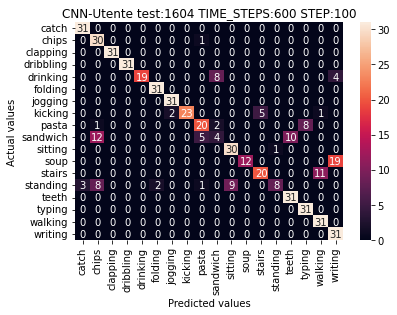

Utente test:  1605
Training: x-> 25431 y-> 25431
Validation: x-> 6358 y-> 6358
Testing: x-> 571 y-> 571
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.1755 - accuracy: 0.2851 - f1_m: 0.1467 - val_loss: 1.6638 - val_accuracy: 0.4574 - val_f1_m: 0.3289
Epoch 2/100
199/199 [==============================] - 6s 33ms/step - loss: 1.5419 - accuracy: 0.4756 - f1_m: 0.3728 - val_loss: 1.2865 - val_accuracy: 0.5854 - val_f1_m: 0.4847
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.3071 - accuracy: 0.5527 - f1_m: 0.4835 - val_loss: 1.1392 - val_accuracy: 0.6147 - val_f1_m: 0.5528
Epoch 4/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1699 - accuracy: 0.5929 - f1_m: 0.5441 - val_loss: 1.0244 - val_accuracy: 0.6450 - val_f1_m: 0.6055
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.0765 - accuracy: 0.6189 - f1_m: 0.5876 - val_loss: 0.9544 - val_accuracy: 0.649

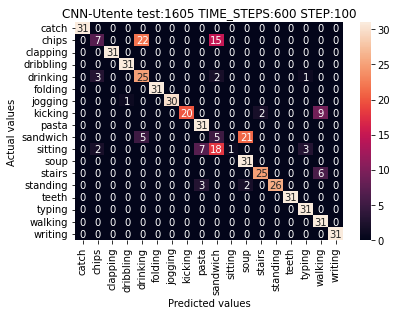

Utente test:  1606
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 7s 34ms/step - loss: 2.0998 - accuracy: 0.3040 - f1_m: 0.1739 - val_loss: 1.5881 - val_accuracy: 0.4801 - val_f1_m: 0.3223
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.5014 - accuracy: 0.4894 - f1_m: 0.4012 - val_loss: 1.2125 - val_accuracy: 0.5836 - val_f1_m: 0.5076
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2665 - accuracy: 0.5656 - f1_m: 0.5056 - val_loss: 1.0494 - val_accuracy: 0.6241 - val_f1_m: 0.5807
Epoch 4/100
199/199 [==============================] - 7s 33ms/step - loss: 1.1332 - accuracy: 0.6034 - f1_m: 0.5636 - val_loss: 0.9465 - val_accuracy: 0.6650 - val_f1_m: 0.6394
Epoch 5/100
199/199 [==============================] - 7s 33ms/step - loss: 1.0487 - accuracy: 0.6288 - f1_m: 0.5948 - val_loss: 0.9226 - val_accuracy: 0.675

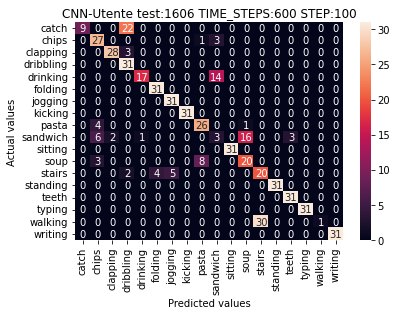

Utente test:  1607
Training: x-> 25434 y-> 25434
Validation: x-> 6359 y-> 6359
Testing: x-> 567 y-> 567
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1147 - accuracy: 0.3046 - f1_m: 0.1624 - val_loss: 1.6219 - val_accuracy: 0.4556 - val_f1_m: 0.3369
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.5118 - accuracy: 0.4897 - f1_m: 0.3995 - val_loss: 1.2626 - val_accuracy: 0.5724 - val_f1_m: 0.5033
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.2982 - accuracy: 0.5572 - f1_m: 0.4897 - val_loss: 1.1343 - val_accuracy: 0.6146 - val_f1_m: 0.5476
Epoch 4/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1766 - accuracy: 0.5907 - f1_m: 0.5366 - val_loss: 1.0192 - val_accuracy: 0.6443 - val_f1_m: 0.6032
Epoch 5/100
199/199 [==============================] - 7s 33ms/step - loss: 1.1012 - accuracy: 0.6133 - f1_m: 0.5690 - val_loss: 0.9724 - val_accuracy: 0.650

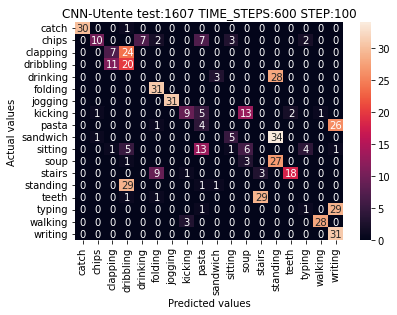

Utente test:  1608
Training: x-> 25415 y-> 25415
Validation: x-> 6354 y-> 6354
Testing: x-> 591 y-> 591
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.0765 - accuracy: 0.3114 - f1_m: 0.1803 - val_loss: 1.5951 - val_accuracy: 0.4865 - val_f1_m: 0.2943
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.4852 - accuracy: 0.5034 - f1_m: 0.4135 - val_loss: 1.2441 - val_accuracy: 0.5792 - val_f1_m: 0.5040
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2652 - accuracy: 0.5657 - f1_m: 0.5066 - val_loss: 1.1083 - val_accuracy: 0.6182 - val_f1_m: 0.5644
Epoch 4/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1184 - accuracy: 0.6100 - f1_m: 0.5722 - val_loss: 0.9841 - val_accuracy: 0.6476 - val_f1_m: 0.6242
Epoch 5/100
199/199 [==============================] - 7s 33ms/step - loss: 1.0163 - accuracy: 0.6453 - f1_m: 0.6165 - val_loss: 0.9170 - val_accuracy: 0.671

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


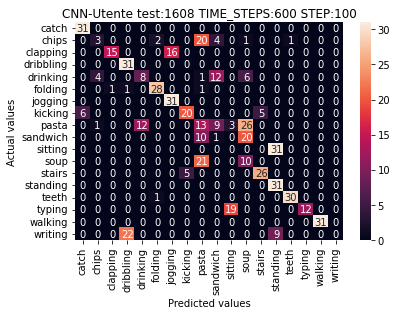

Utente test:  1609
Training: x-> 25405 y-> 25405
Validation: x-> 6352 y-> 6352
Testing: x-> 603 y-> 603
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.1270 - accuracy: 0.2976 - f1_m: 0.1664 - val_loss: 1.6086 - val_accuracy: 0.4501 - val_f1_m: 0.2992
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.5263 - accuracy: 0.4797 - f1_m: 0.3936 - val_loss: 1.2264 - val_accuracy: 0.5723 - val_f1_m: 0.4992
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2952 - accuracy: 0.5553 - f1_m: 0.4929 - val_loss: 1.0868 - val_accuracy: 0.6281 - val_f1_m: 0.5755
Epoch 4/100
199/199 [==============================] - 7s 33ms/step - loss: 1.1508 - accuracy: 0.6006 - f1_m: 0.5558 - val_loss: 0.9769 - val_accuracy: 0.6540 - val_f1_m: 0.6329
Epoch 5/100
199/199 [==============================] - 7s 33ms/step - loss: 1.0619 - accuracy: 0.6260 - f1_m: 0.5912 - val_loss: 0.9086 - val_accuracy: 0.678

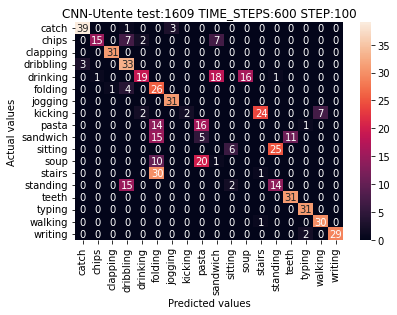

Utente test:  1610
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1315 - accuracy: 0.3008 - f1_m: 0.1680 - val_loss: 1.5252 - val_accuracy: 0.4944 - val_f1_m: 0.3480
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.5260 - accuracy: 0.4828 - f1_m: 0.3934 - val_loss: 1.2760 - val_accuracy: 0.5590 - val_f1_m: 0.4526
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.3030 - accuracy: 0.5510 - f1_m: 0.4849 - val_loss: 1.0611 - val_accuracy: 0.6288 - val_f1_m: 0.5905
Epoch 4/100
199/199 [==============================] - 7s 35ms/step - loss: 1.1741 - accuracy: 0.5893 - f1_m: 0.5397 - val_loss: 0.9773 - val_accuracy: 0.6623 - val_f1_m: 0.6059
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.0832 - accuracy: 0.6206 - f1_m: 0.5775 - val_loss: 0.9104 - val_accuracy: 0.687

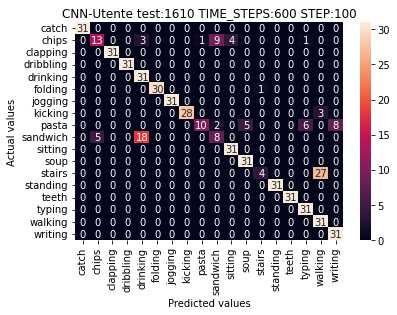

Utente test:  1611
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.1472 - accuracy: 0.2925 - f1_m: 0.1596 - val_loss: 1.6502 - val_accuracy: 0.4658 - val_f1_m: 0.2963
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.5123 - accuracy: 0.4850 - f1_m: 0.3954 - val_loss: 1.3921 - val_accuracy: 0.5362 - val_f1_m: 0.4609
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2726 - accuracy: 0.5606 - f1_m: 0.5025 - val_loss: 1.1634 - val_accuracy: 0.5870 - val_f1_m: 0.5506
Epoch 4/100
199/199 [==============================] - 7s 33ms/step - loss: 1.1252 - accuracy: 0.6141 - f1_m: 0.5696 - val_loss: 0.9610 - val_accuracy: 0.6633 - val_f1_m: 0.6268
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.0355 - accuracy: 0.6375 - f1_m: 0.6046 - val_loss: 0.9312 - val_accuracy: 0.688

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


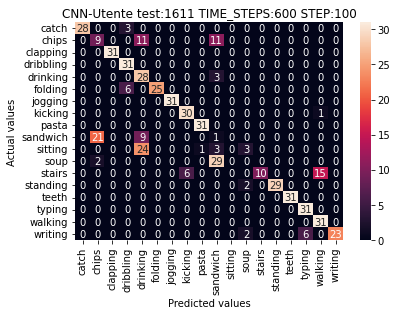

Utente test:  1612
Training: x-> 25439 y-> 25439
Validation: x-> 6360 y-> 6360
Testing: x-> 561 y-> 561
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1146 - accuracy: 0.3007 - f1_m: 0.1685 - val_loss: 1.6105 - val_accuracy: 0.4553 - val_f1_m: 0.3269
Epoch 2/100
199/199 [==============================] - 7s 35ms/step - loss: 1.5306 - accuracy: 0.4824 - f1_m: 0.3961 - val_loss: 1.3597 - val_accuracy: 0.5406 - val_f1_m: 0.4560
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.3105 - accuracy: 0.5519 - f1_m: 0.4918 - val_loss: 1.1112 - val_accuracy: 0.6082 - val_f1_m: 0.5649
Epoch 4/100
199/199 [==============================] - 7s 35ms/step - loss: 1.1723 - accuracy: 0.5942 - f1_m: 0.5465 - val_loss: 1.0612 - val_accuracy: 0.6283 - val_f1_m: 0.5926
Epoch 5/100
199/199 [==============================] - 7s 35ms/step - loss: 1.0802 - accuracy: 0.6235 - f1_m: 0.5828 - val_loss: 0.9882 - val_accuracy: 0.655

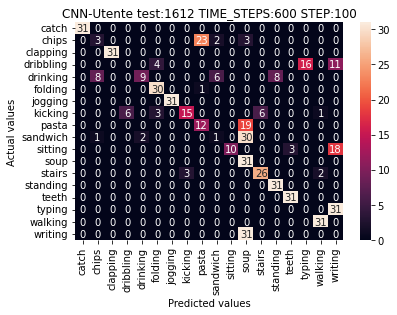

Utente test:  1613
Training: x-> 25444 y-> 25444
Validation: x-> 6361 y-> 6361
Testing: x-> 555 y-> 555
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 37ms/step - loss: 2.1866 - accuracy: 0.2789 - f1_m: 0.1469 - val_loss: 1.6747 - val_accuracy: 0.4616 - val_f1_m: 0.2769
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.5658 - accuracy: 0.4677 - f1_m: 0.3747 - val_loss: 1.3029 - val_accuracy: 0.5856 - val_f1_m: 0.4629
Epoch 3/100
199/199 [==============================] - 7s 35ms/step - loss: 1.3567 - accuracy: 0.5347 - f1_m: 0.4663 - val_loss: 1.1147 - val_accuracy: 0.6115 - val_f1_m: 0.5594
Epoch 4/100
199/199 [==============================] - 7s 35ms/step - loss: 1.2303 - accuracy: 0.5713 - f1_m: 0.5182 - val_loss: 1.0686 - val_accuracy: 0.6148 - val_f1_m: 0.5779
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1264 - accuracy: 0.6021 - f1_m: 0.5625 - val_loss: 0.9679 - val_accuracy: 0.662

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


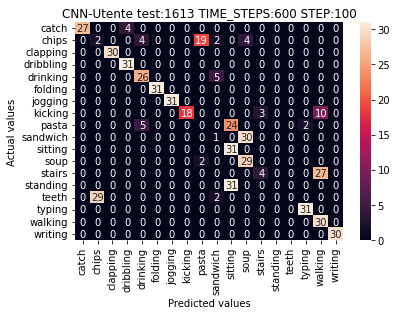

Utente test:  1614
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1764 - accuracy: 0.2857 - f1_m: 0.1504 - val_loss: 1.5819 - val_accuracy: 0.4658 - val_f1_m: 0.3339
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.5163 - accuracy: 0.4870 - f1_m: 0.3976 - val_loss: 1.2226 - val_accuracy: 0.5727 - val_f1_m: 0.5184
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2869 - accuracy: 0.5564 - f1_m: 0.4902 - val_loss: 1.0872 - val_accuracy: 0.6181 - val_f1_m: 0.5784
Epoch 4/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1676 - accuracy: 0.5982 - f1_m: 0.5476 - val_loss: 1.0518 - val_accuracy: 0.6386 - val_f1_m: 0.5964
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.0642 - accuracy: 0.6299 - f1_m: 0.5904 - val_loss: 0.9853 - val_accuracy: 0.658

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


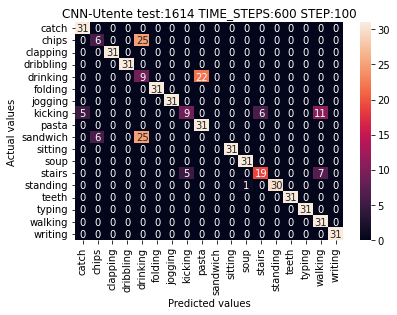

Utente test:  1615
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1137 - accuracy: 0.3113 - f1_m: 0.1825 - val_loss: 1.6747 - val_accuracy: 0.4389 - val_f1_m: 0.3241
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.5039 - accuracy: 0.4906 - f1_m: 0.3996 - val_loss: 1.2535 - val_accuracy: 0.5730 - val_f1_m: 0.4846
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.2759 - accuracy: 0.5567 - f1_m: 0.4935 - val_loss: 1.1038 - val_accuracy: 0.6185 - val_f1_m: 0.5708
Epoch 4/100
199/199 [==============================] - 7s 33ms/step - loss: 1.1361 - accuracy: 0.6022 - f1_m: 0.5571 - val_loss: 1.0164 - val_accuracy: 0.6625 - val_f1_m: 0.5912
Epoch 5/100
199/199 [==============================] - 7s 35ms/step - loss: 1.0475 - accuracy: 0.6356 - f1_m: 0.5986 - val_loss: 0.9208 - val_accuracy: 0.690

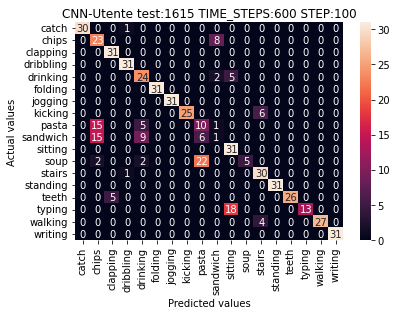

Utente test:  1616
Training: x-> 25466 y-> 25466
Validation: x-> 6367 y-> 6367
Testing: x-> 527 y-> 527
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1107 - accuracy: 0.3100 - f1_m: 0.1772 - val_loss: 1.7082 - val_accuracy: 0.4479 - val_f1_m: 0.2954
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.4992 - accuracy: 0.4953 - f1_m: 0.4042 - val_loss: 1.3172 - val_accuracy: 0.5522 - val_f1_m: 0.4862
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2806 - accuracy: 0.5615 - f1_m: 0.4977 - val_loss: 1.1622 - val_accuracy: 0.6169 - val_f1_m: 0.5567
Epoch 4/100
199/199 [==============================] - 7s 35ms/step - loss: 1.1371 - accuracy: 0.6080 - f1_m: 0.5635 - val_loss: 0.9873 - val_accuracy: 0.6667 - val_f1_m: 0.6340
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.0417 - accuracy: 0.6412 - f1_m: 0.6039 - val_loss: 0.9600 - val_accuracy: 0.668

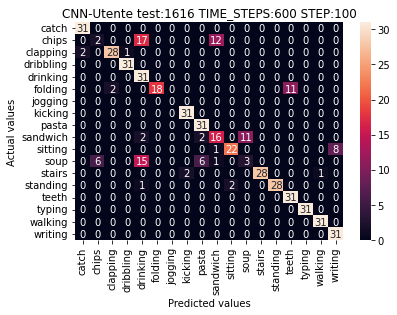

Utente test:  1617
Training: x-> 25424 y-> 25424
Validation: x-> 6357 y-> 6357
Testing: x-> 579 y-> 579
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.2820 - accuracy: 0.2490 - f1_m: 0.1139 - val_loss: 1.7861 - val_accuracy: 0.4030 - val_f1_m: 0.2486
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.6561 - accuracy: 0.4428 - f1_m: 0.3335 - val_loss: 1.4449 - val_accuracy: 0.5201 - val_f1_m: 0.3970
Epoch 3/100
199/199 [==============================] - 7s 35ms/step - loss: 1.4635 - accuracy: 0.4969 - f1_m: 0.4202 - val_loss: 1.2796 - val_accuracy: 0.5731 - val_f1_m: 0.4748
Epoch 4/100
199/199 [==============================] - 7s 33ms/step - loss: 1.3571 - accuracy: 0.5286 - f1_m: 0.4627 - val_loss: 1.1432 - val_accuracy: 0.6001 - val_f1_m: 0.5463
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.2740 - accuracy: 0.5561 - f1_m: 0.5024 - val_loss: 1.0622 - val_accuracy: 0.622

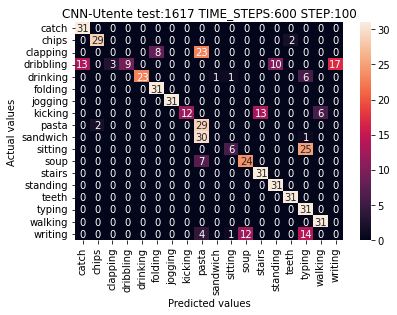

Utente test:  1618
Training: x-> 25466 y-> 25466
Validation: x-> 6367 y-> 6367
Testing: x-> 527 y-> 527
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.1134 - accuracy: 0.3020 - f1_m: 0.1713 - val_loss: 1.5509 - val_accuracy: 0.4968 - val_f1_m: 0.3181
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.4797 - accuracy: 0.5018 - f1_m: 0.4094 - val_loss: 1.2112 - val_accuracy: 0.5792 - val_f1_m: 0.4979
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2588 - accuracy: 0.5653 - f1_m: 0.5021 - val_loss: 1.0448 - val_accuracy: 0.6231 - val_f1_m: 0.5739
Epoch 4/100
199/199 [==============================] - 7s 35ms/step - loss: 1.1172 - accuracy: 0.6120 - f1_m: 0.5666 - val_loss: 0.9336 - val_accuracy: 0.6763 - val_f1_m: 0.6355
Epoch 5/100
199/199 [==============================] - 7s 35ms/step - loss: 1.0303 - accuracy: 0.6403 - f1_m: 0.6056 - val_loss: 0.8660 - val_accuracy: 0.694

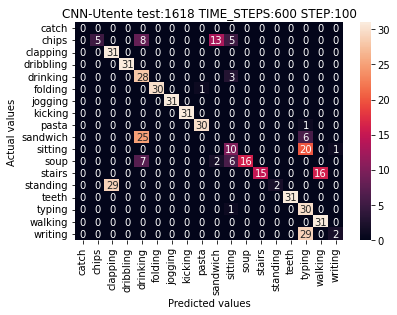

Utente test:  1619
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.1354 - accuracy: 0.2962 - f1_m: 0.1718 - val_loss: 1.7036 - val_accuracy: 0.4347 - val_f1_m: 0.2996
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.5226 - accuracy: 0.4851 - f1_m: 0.3939 - val_loss: 1.2812 - val_accuracy: 0.5735 - val_f1_m: 0.4777
Epoch 3/100
199/199 [==============================] - 7s 35ms/step - loss: 1.2803 - accuracy: 0.5595 - f1_m: 0.4952 - val_loss: 1.1153 - val_accuracy: 0.6159 - val_f1_m: 0.5702
Epoch 4/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1561 - accuracy: 0.5969 - f1_m: 0.5483 - val_loss: 1.1886 - val_accuracy: 0.5919 - val_f1_m: 0.5574
Epoch 5/100
199/199 [==============================] - 7s 35ms/step - loss: 1.0641 - accuracy: 0.6264 - f1_m: 0.5840 - val_loss: 1.0124 - val_accuracy: 0.654

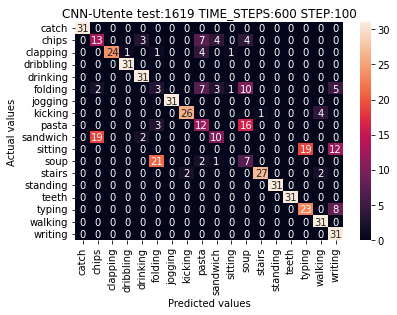

Utente test:  1620
Training: x-> 25423 y-> 25423
Validation: x-> 6356 y-> 6356
Testing: x-> 581 y-> 581
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.3061 - accuracy: 0.2458 - f1_m: 0.1163 - val_loss: 1.7707 - val_accuracy: 0.4158 - val_f1_m: 0.2439
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.6426 - accuracy: 0.4493 - f1_m: 0.3491 - val_loss: 1.3612 - val_accuracy: 0.5491 - val_f1_m: 0.4418
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.3948 - accuracy: 0.5271 - f1_m: 0.4546 - val_loss: 1.2027 - val_accuracy: 0.5883 - val_f1_m: 0.5078
Epoch 4/100
199/199 [==============================] - 7s 35ms/step - loss: 1.2582 - accuracy: 0.5689 - f1_m: 0.5103 - val_loss: 1.1290 - val_accuracy: 0.5963 - val_f1_m: 0.5403
Epoch 5/100
199/199 [==============================] - 7s 33ms/step - loss: 1.1576 - accuracy: 0.5984 - f1_m: 0.5487 - val_loss: 1.0630 - val_accuracy: 0.633

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


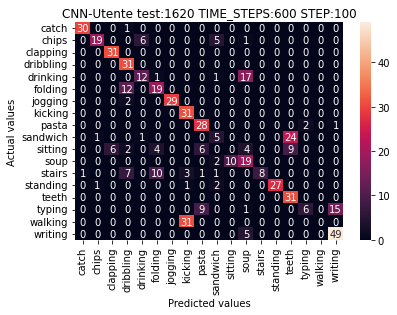

Utente test:  1621
Training: x-> 25389 y-> 25389
Validation: x-> 6348 y-> 6348
Testing: x-> 623 y-> 623
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1828 - accuracy: 0.2809 - f1_m: 0.1494 - val_loss: 1.7734 - val_accuracy: 0.4217 - val_f1_m: 0.2613
Epoch 2/100
199/199 [==============================] - 7s 35ms/step - loss: 1.5577 - accuracy: 0.4732 - f1_m: 0.3727 - val_loss: 1.3211 - val_accuracy: 0.5595 - val_f1_m: 0.4366
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.3371 - accuracy: 0.5461 - f1_m: 0.4709 - val_loss: 1.2295 - val_accuracy: 0.5761 - val_f1_m: 0.5011
Epoch 4/100
199/199 [==============================] - 7s 35ms/step - loss: 1.1938 - accuracy: 0.5875 - f1_m: 0.5353 - val_loss: 1.0620 - val_accuracy: 0.6498 - val_f1_m: 0.5759
Epoch 5/100
199/199 [==============================] - 7s 35ms/step - loss: 1.1068 - accuracy: 0.6127 - f1_m: 0.5738 - val_loss: 0.9515 - val_accuracy: 0.674

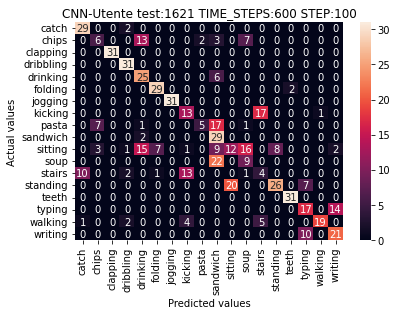

Utente test:  1622
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.1607 - accuracy: 0.2931 - f1_m: 0.1689 - val_loss: 1.5955 - val_accuracy: 0.4844 - val_f1_m: 0.2989
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.4990 - accuracy: 0.4950 - f1_m: 0.4025 - val_loss: 1.3020 - val_accuracy: 0.5612 - val_f1_m: 0.4500
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.2892 - accuracy: 0.5590 - f1_m: 0.4970 - val_loss: 1.0732 - val_accuracy: 0.6238 - val_f1_m: 0.5733
Epoch 4/100
199/199 [==============================] - 7s 35ms/step - loss: 1.1692 - accuracy: 0.5950 - f1_m: 0.5475 - val_loss: 1.0200 - val_accuracy: 0.6425 - val_f1_m: 0.6138
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.0738 - accuracy: 0.6249 - f1_m: 0.5908 - val_loss: 0.9120 - val_accuracy: 0.680

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


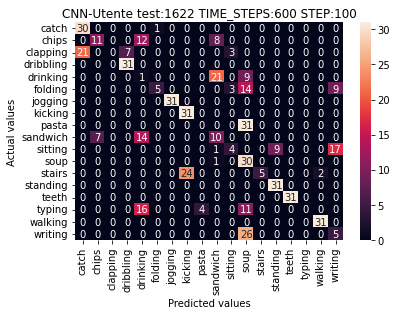

Utente test:  1623
Training: x-> 25442 y-> 25442
Validation: x-> 6361 y-> 6361
Testing: x-> 557 y-> 557
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1444 - accuracy: 0.2940 - f1_m: 0.1614 - val_loss: 1.7202 - val_accuracy: 0.4397 - val_f1_m: 0.2845
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.5348 - accuracy: 0.4786 - f1_m: 0.3895 - val_loss: 1.3192 - val_accuracy: 0.5543 - val_f1_m: 0.4687
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.3327 - accuracy: 0.5449 - f1_m: 0.4718 - val_loss: 1.1572 - val_accuracy: 0.5991 - val_f1_m: 0.5367
Epoch 4/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1932 - accuracy: 0.5847 - f1_m: 0.5304 - val_loss: 1.0338 - val_accuracy: 0.6499 - val_f1_m: 0.6105
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1046 - accuracy: 0.6121 - f1_m: 0.5675 - val_loss: 0.9935 - val_accuracy: 0.656

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


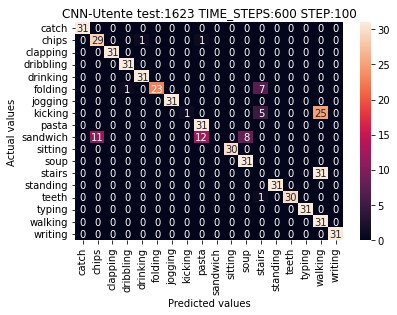

Utente test:  1624
Training: x-> 25391 y-> 25391
Validation: x-> 6348 y-> 6348
Testing: x-> 621 y-> 621
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1076 - accuracy: 0.3105 - f1_m: 0.1848 - val_loss: 1.5772 - val_accuracy: 0.4787 - val_f1_m: 0.3183
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.4790 - accuracy: 0.5051 - f1_m: 0.4240 - val_loss: 1.2802 - val_accuracy: 0.5770 - val_f1_m: 0.4647
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.2549 - accuracy: 0.5708 - f1_m: 0.5152 - val_loss: 1.0388 - val_accuracy: 0.6385 - val_f1_m: 0.5884
Epoch 4/100
199/199 [==============================] - 7s 35ms/step - loss: 1.1244 - accuracy: 0.6115 - f1_m: 0.5662 - val_loss: 0.9800 - val_accuracy: 0.6654 - val_f1_m: 0.6193
Epoch 5/100
199/199 [==============================] - 7s 35ms/step - loss: 1.0280 - accuracy: 0.6400 - f1_m: 0.6083 - val_loss: 0.8666 - val_accuracy: 0.697

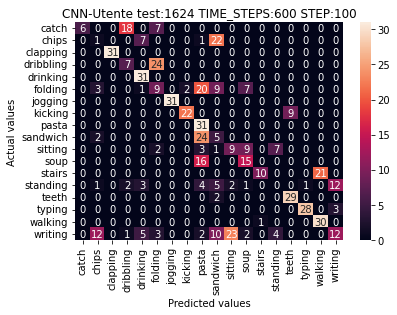

Utente test:  1625
Training: x-> 25427 y-> 25427
Validation: x-> 6357 y-> 6357
Testing: x-> 576 y-> 576
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.3060 - accuracy: 0.2400 - f1_m: 0.1161 - val_loss: 1.7153 - val_accuracy: 0.4565 - val_f1_m: 0.2456
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.6753 - accuracy: 0.4445 - f1_m: 0.3336 - val_loss: 1.3641 - val_accuracy: 0.5482 - val_f1_m: 0.4480
Epoch 3/100
199/199 [==============================] - 7s 35ms/step - loss: 1.4146 - accuracy: 0.5185 - f1_m: 0.4388 - val_loss: 1.2422 - val_accuracy: 0.5830 - val_f1_m: 0.5039
Epoch 4/100
199/199 [==============================] - 7s 34ms/step - loss: 1.2759 - accuracy: 0.5584 - f1_m: 0.4949 - val_loss: 1.0907 - val_accuracy: 0.6160 - val_f1_m: 0.5632
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1864 - accuracy: 0.5875 - f1_m: 0.5341 - val_loss: 1.0276 - val_accuracy: 0.643

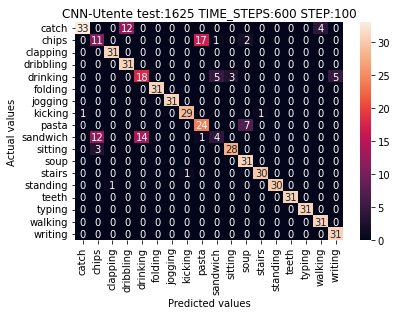

Utente test:  1626
Training: x-> 25422 y-> 25422
Validation: x-> 6356 y-> 6356
Testing: x-> 582 y-> 582
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1721 - accuracy: 0.2858 - f1_m: 0.1562 - val_loss: 1.7531 - val_accuracy: 0.4290 - val_f1_m: 0.2858
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.5604 - accuracy: 0.4781 - f1_m: 0.3806 - val_loss: 1.3507 - val_accuracy: 0.5472 - val_f1_m: 0.4419
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.3372 - accuracy: 0.5511 - f1_m: 0.4798 - val_loss: 1.1800 - val_accuracy: 0.6015 - val_f1_m: 0.5385
Epoch 4/100
199/199 [==============================] - 7s 34ms/step - loss: 1.2077 - accuracy: 0.5798 - f1_m: 0.5297 - val_loss: 1.0345 - val_accuracy: 0.6503 - val_f1_m: 0.6070
Epoch 5/100
199/199 [==============================] - 7s 35ms/step - loss: 1.1177 - accuracy: 0.6108 - f1_m: 0.5700 - val_loss: 1.0227 - val_accuracy: 0.655

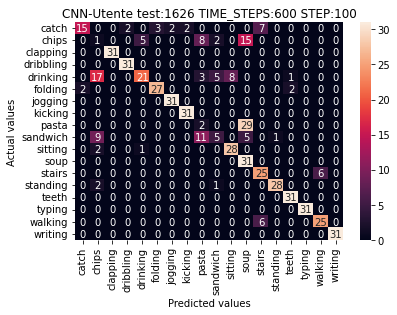

Utente test:  1627
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.0983 - accuracy: 0.3087 - f1_m: 0.1819 - val_loss: 1.5621 - val_accuracy: 0.4729 - val_f1_m: 0.3519
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.4898 - accuracy: 0.4997 - f1_m: 0.4148 - val_loss: 1.3552 - val_accuracy: 0.5505 - val_f1_m: 0.4602
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.2795 - accuracy: 0.5621 - f1_m: 0.5034 - val_loss: 1.1386 - val_accuracy: 0.6131 - val_f1_m: 0.5515
Epoch 4/100
199/199 [==============================] - 7s 35ms/step - loss: 1.1368 - accuracy: 0.6103 - f1_m: 0.5675 - val_loss: 0.9868 - val_accuracy: 0.6603 - val_f1_m: 0.6338
Epoch 5/100
199/199 [==============================] - 7s 35ms/step - loss: 1.0399 - accuracy: 0.6381 - f1_m: 0.6061 - val_loss: 0.9094 - val_accuracy: 0.687

In [ ]:
import itertools
import gc
from tabnanny import verbose
from tkinter import Y
batchsize=128

if leave_one_subject_out:
    cnn_results_dict = []
    cnn_results = pd.DataFrame()
    try:
        mkdir(cnn_dir + leave_one_subject_out_dir)
        mkdir(cnn_dir + leave_one_subject_out_dir + plot_dir)
    except OSError as error:
        print(error)

    for config in itertools.product(time_steps_list, step_list):

        time_step = config[0]
        step=config[1]

        cnn_f1_macro = []
        cnn_f1_weighted = []
        cnn_acc = []
        cnn_class_reports = []
        cnn_confusion_matrixes = []

        print(time_step,step)

        for user_id in users_ids:
            print("Utente test: ", user_id)

            X_test = np.array(data_cnn[time_step][step][user_id][0])
            y_test = np.array(data_cnn[time_step][step][user_id][1])

            X_train = []
            y_train = []

            for id in users_ids:
                if not id == user_id:
                    X_train += data_cnn[time_step][step][id][0]
                    y_train += data_cnn[time_step][step][id][1]
            
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            scaler = RobustScaler()
            X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
            X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

            y_train = enc.transform(y_train)
            y_test = enc.transform(y_test)

            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

      #      print(X_train)
       #     print(y_train)
        #    print(X_test)

         #   print(y_test)

            model = createCNN(X_train[0].shape, y_train[0].shape[0])

            callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

            XTraining, XValidation, YTraining, YValidation = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

            print("Training: x->",len(XTraining),"y->",len(YTraining))
            print("Validation: x->",len(XValidation),"y->",len(YValidation))
            print("Testing: x->",len(X_test),"y->",len(y_test))
            print("Total: x->",len(XTraining)+len(XValidation)+len(X_test),"y->",len(YTraining)+len(YValidation)+len(y_test))

            model.fit(XTraining, YTraining, batch_size = batchsize, epochs = 100, validation_data=(XValidation,YValidation), verbose=1, callbacks=[callback], shuffle=True, workers=10, use_multiprocessing=True )

            rounded_labels=np.argmax(y_test, axis=1)
            y_pred = np.argmax(model.predict(X_test), axis=-1)

            cnn_acc.append(accuracy_score(rounded_labels, y_pred))
            cnn_f1_weighted.append(f1_score(rounded_labels, y_pred, average='weighted'))
            cnn_f1_macro.append(f1_score(rounded_labels, y_pred, average='macro'))
            #cnn_f1.append(f1_m(rounded_labels,y_pred))

            class_report = classification_report(rounded_labels, y_pred, digits=4)
            print(class_report)
            cnn_class_reports.append(class_report)
            
            conf_matrix = confusion_matrix(rounded_labels, y_pred, labels=range(0,len(enc.categories_[0])))

            ax = seaborn.heatmap(conf_matrix, annot=True, fmt='d')

            ax.set_title("CNN-Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))

            ax.set_xlabel('Predicted values')
            ax.set_ylabel('Actual values')

            ax.xaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=90)
            ax.yaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=0)

            ax.get_figure().savefig(cnn_dir + leave_one_subject_out_dir + plot_dir +'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
            #model_history_file=open(cnn_dir+'/'+ax.get_title().replace(":"," ")+".txt", "w")
            #model_history_file.write(model.history())
            #model_history_file.close()

            cnn_confusion_matrixes.append(ax)
            plt.show()

            gc.collect()            

        print("Accuracy media:",np.mean(cnn_acc))
        print("F1 weighted media:",np.mean(cnn_f1_weighted))
        print("F1 macro media:",np.mean(cnn_f1_macro))

        cnn_results_dict.append({
            'Time Steps':time_step,
            'Step':step,
            'Average accuracy':np.mean(cnn_acc),
            'Average F1 Weighted': np.mean(cnn_f1_weighted),
            'Average F1 Macro': np.mean(cnn_f1_macro),
            'reports':cnn_class_reports,
            'confusion_matrix':cnn_confusion_matrixes
        })
        
        cnn_results = pd.DataFrame(cnn_results_dict)
        print(cnn_results)
        cnn_results.to_csv(cnn_dir + leave_one_subject_out_dir + result_filename)


In [ ]:
print(np.unique(y_pred))
print(np.unique(y_test))

[ 0  1  3  4  5  6  7  8  9 10 11 13 16 17]
[0. 1.]


# Bi-LSTM

In [ ]:
bilstm_dir = folder_name + "\\bilstm"
bilstm_plot_dir = bilstm_dir + "\\plot"
bilstm_result_filename = bilstm_dir + "\\result.csv"
bilstm_config_filename = bilstm_dir + "\\config_bilstm.txt"

mkdir(bilstm_dir)
mkdir(bilstm_plot_dir)

In [ ]:
def createBiLSTM(input_size, output_size):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=64, return_sequences=True, input_shape=input_size)))
    model.add(Dropout(rate=0.2))
    model.add(Bidirectional(LSTM(units=64)))
    model.add(Dropout(rate=0.2))

    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(output_size, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    
    return model

In [ ]:
data_cnn = tuple_by_timestep

600 100
Utente test:  1600
Epoch 1/100
199/199 [==============================] - 29s 115ms/step - loss: 2.4923 - accuracy: 0.2032 - val_loss: 2.1720 - val_accuracy: 0.2909
Epoch 2/100
199/199 [==============================] - 22s 110ms/step - loss: 2.1897 - accuracy: 0.2818 - val_loss: 2.0259 - val_accuracy: 0.3151
Epoch 3/100
199/199 [==============================] - 22s 110ms/step - loss: 2.0565 - accuracy: 0.3095 - val_loss: 1.9340 - val_accuracy: 0.3601
Epoch 4/100
199/199 [==============================] - 22s 113ms/step - loss: 1.9622 - accuracy: 0.3390 - val_loss: 1.8800 - val_accuracy: 0.3662
Epoch 5/100
199/199 [==============================] - 23s 113ms/step - loss: 1.9402 - accuracy: 0.3431 - val_loss: 1.8772 - val_accuracy: 0.3808
Epoch 6/100
199/199 [==============================] - 23s 116ms/step - loss: 2.0704 - accuracy: 0.3178 - val_loss: 1.8589 - val_accuracy: 0.3646
Epoch 7/100
199/199 [==============================] - 22s 111ms/step - loss: 1.9545 - accuracy: 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.9394    1.0000    0.9688        31
           1     0.1053    0.0645    0.0800        31
           2     0.0000    0.0000    0.0000        31
           3     1.0000    1.0000    1.0000        31
           4     0.0000    0.0000    0.0000        31
           5     1.0000    0.6111    0.7586        36
           6     1.0000    1.0000    1.0000        31
           7     0.0000    0.0000    0.0000        31
           8     0.2667    0.2581    0.2623        31
           9     0.0000    0.0000    0.0000        31
          10     0.9688    1.0000    0.9841        31
          11     0.4524    0.6129    0.5205        31
          12     0.3939    0.4194    0.4062        31
          13     0.9394    1.0000    0.9688        31
          14     0.2583    1.0000    0.4106        31
          15     1.0000    1.0000    1.0000        31
          16     0.4667    0.9032    0.6154        31
          17     1.0000    

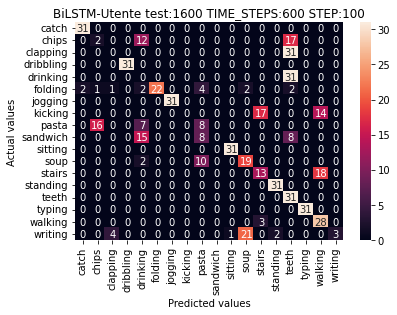

Utente test:  1602
Epoch 1/100
199/199 [==============================] - 29s 117ms/step - loss: 2.4964 - accuracy: 0.2029 - val_loss: 2.0641 - val_accuracy: 0.3177
Epoch 2/100
199/199 [==============================] - 22s 111ms/step - loss: 2.1025 - accuracy: 0.3059 - val_loss: 1.8575 - val_accuracy: 0.3834
Epoch 3/100
199/199 [==============================] - 22s 112ms/step - loss: 1.9665 - accuracy: 0.3460 - val_loss: 1.8108 - val_accuracy: 0.3874
Epoch 4/100
199/199 [==============================] - 23s 115ms/step - loss: 1.9666 - accuracy: 0.3580 - val_loss: 1.9005 - val_accuracy: 0.3663
Epoch 5/100
199/199 [==============================] - 22s 113ms/step - loss: 1.8554 - accuracy: 0.3831 - val_loss: 1.5690 - val_accuracy: 0.4653
Epoch 6/100
199/199 [==============================] - 22s 113ms/step - loss: 1.8254 - accuracy: 0.3878 - val_loss: 1.7215 - val_accuracy: 0.4278
Epoch 7/100
199/199 [==============================] - 22s 112ms/step - loss: 1.8529 - accuracy: 0.3852 -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


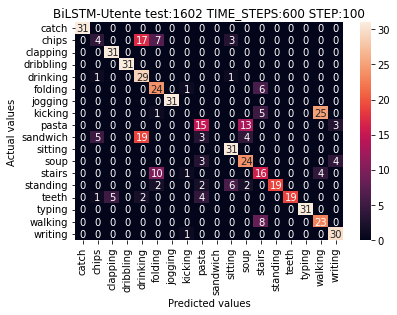

Utente test:  1604
Epoch 1/100
199/199 [==============================] - 29s 119ms/step - loss: 2.4610 - accuracy: 0.2079 - val_loss: 2.1404 - val_accuracy: 0.2932
Epoch 2/100
199/199 [==============================] - 22s 112ms/step - loss: 2.1290 - accuracy: 0.2965 - val_loss: 1.9983 - val_accuracy: 0.3287
Epoch 3/100
199/199 [==============================] - 22s 112ms/step - loss: 2.0135 - accuracy: 0.3241 - val_loss: 1.8272 - val_accuracy: 0.3712
Epoch 4/100
199/199 [==============================] - 22s 113ms/step - loss: 2.0436 - accuracy: 0.3133 - val_loss: 1.9032 - val_accuracy: 0.3532
Epoch 5/100
199/199 [==============================] - 22s 113ms/step - loss: 1.9618 - accuracy: 0.3389 - val_loss: 2.0799 - val_accuracy: 0.3446
Epoch 6/100
199/199 [==============================] - 22s 113ms/step - loss: 1.9764 - accuracy: 0.3459 - val_loss: 1.7837 - val_accuracy: 0.3845
Epoch 7/100
199/199 [==============================] - 22s 113ms/step - loss: 2.0202 - accuracy: 0.3390 -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


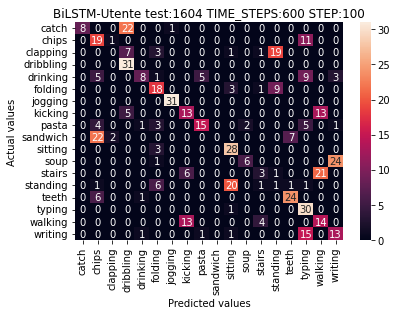

Utente test:  1605
Epoch 1/100
199/199 [==============================] - 29s 119ms/step - loss: 2.4795 - accuracy: 0.2058 - val_loss: 2.0691 - val_accuracy: 0.3312
Epoch 2/100
199/199 [==============================] - 23s 114ms/step - loss: 2.1276 - accuracy: 0.3001 - val_loss: 1.9379 - val_accuracy: 0.3501
Epoch 3/100
199/199 [==============================] - 23s 114ms/step - loss: 2.0282 - accuracy: 0.3274 - val_loss: 1.7965 - val_accuracy: 0.3935
Epoch 4/100
199/199 [==============================] - 23s 113ms/step - loss: 1.9364 - accuracy: 0.3506 - val_loss: 1.8646 - val_accuracy: 0.3806
Epoch 5/100
199/199 [==============================] - 23s 114ms/step - loss: 1.9421 - accuracy: 0.3559 - val_loss: 2.1896 - val_accuracy: 0.3009
Epoch 6/100
199/199 [==============================] - 23s 114ms/step - loss: 2.1637 - accuracy: 0.2948 - val_loss: 2.1919 - val_accuracy: 0.2811
Epoch 7/100
199/199 [==============================] - 23s 114ms/step - loss: 2.1104 - accuracy: 0.3058 -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


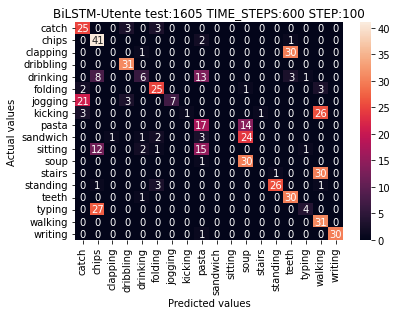

Utente test:  1606
Epoch 1/100
199/199 [==============================] - 29s 120ms/step - loss: 2.4645 - accuracy: 0.2065 - val_loss: 2.1588 - val_accuracy: 0.2979
Epoch 2/100
199/199 [==============================] - 23s 116ms/step - loss: 2.1935 - accuracy: 0.2796 - val_loss: 1.9140 - val_accuracy: 0.3459
Epoch 3/100
199/199 [==============================] - 22s 113ms/step - loss: 2.0040 - accuracy: 0.3267 - val_loss: 1.8134 - val_accuracy: 0.3841
Epoch 4/100
199/199 [==============================] - 23s 114ms/step - loss: 1.9234 - accuracy: 0.3541 - val_loss: 1.7617 - val_accuracy: 0.4081
Epoch 5/100
199/199 [==============================] - 23s 114ms/step - loss: 1.9594 - accuracy: 0.3399 - val_loss: 1.7789 - val_accuracy: 0.3974
Epoch 6/100
199/199 [==============================] - 23s 114ms/step - loss: 1.9039 - accuracy: 0.3674 - val_loss: 1.7657 - val_accuracy: 0.4045
Epoch 7/100
199/199 [==============================] - 23s 114ms/step - loss: 1.8926 - accuracy: 0.3636 -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.5455    0.5806    0.5625        31
           1     0.9000    0.2903    0.4390        31
           2     0.0588    0.1290    0.0808        31
           3     0.0400    0.0323    0.0357        31
           4     0.1000    0.0645    0.0784        31
           5     0.5161    0.5161    0.5161        31
           6     0.3924    1.0000    0.5636        31
           7     0.3077    0.1290    0.1818        31
           8     0.5882    0.3226    0.4167        31
           9     0.0000    0.0000    0.0000        31
          10     0.9688    1.0000    0.9841        31
          11     0.4643    0.8387    0.5977        31
          12     0.0806    0.1613    0.1075        31
          13     0.6667    0.1290    0.2162        31
          14     0.1304    0.0968    0.1111        31
          15     1.0000    0.9355    0.9667        31
          16     0.0870    0.0645    0.0741        31
          17     1.0000    

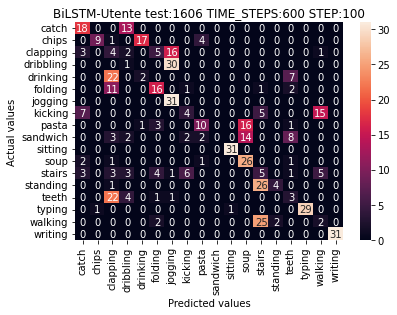

Utente test:  1610
Epoch 1/100
199/199 [==============================] - 29s 118ms/step - loss: 2.5057 - accuracy: 0.2052 - val_loss: 2.1338 - val_accuracy: 0.3091
Epoch 2/100
199/199 [==============================] - 22s 112ms/step - loss: 2.1888 - accuracy: 0.2815 - val_loss: 1.9535 - val_accuracy: 0.3499
Epoch 3/100
199/199 [==============================] - 23s 113ms/step - loss: 2.0269 - accuracy: 0.3165 - val_loss: 1.8052 - val_accuracy: 0.4018
Epoch 4/100
199/199 [==============================] - 23s 114ms/step - loss: 1.9663 - accuracy: 0.3411 - val_loss: 1.7730 - val_accuracy: 0.3930
Epoch 5/100
199/199 [==============================] - 23s 113ms/step - loss: 1.9199 - accuracy: 0.3592 - val_loss: 1.9579 - val_accuracy: 0.3512
Epoch 6/100
199/199 [==============================] - 23s 113ms/step - loss: 1.9191 - accuracy: 0.3573 - val_loss: 1.7153 - val_accuracy: 0.3979
Epoch 7/100
199/199 [==============================] - 23s 115ms/step - loss: 1.9561 - accuracy: 0.3334 -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


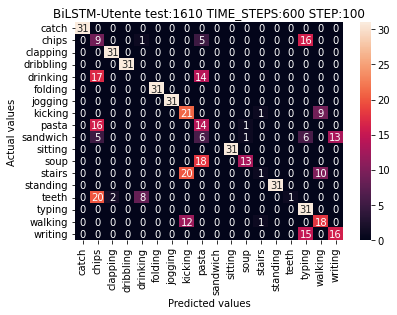

Utente test:  1611
Epoch 1/100
199/199 [==============================] - 29s 120ms/step - loss: 2.4784 - accuracy: 0.2020 - val_loss: 2.1142 - val_accuracy: 0.3025
Epoch 2/100
199/199 [==============================] - 23s 114ms/step - loss: 2.1518 - accuracy: 0.2861 - val_loss: 1.9831 - val_accuracy: 0.3441
Epoch 3/100
199/199 [==============================] - 23s 114ms/step - loss: 2.0554 - accuracy: 0.3087 - val_loss: 1.8344 - val_accuracy: 0.3781
Epoch 4/100
199/199 [==============================] - 23s 114ms/step - loss: 1.9538 - accuracy: 0.3343 - val_loss: 1.7266 - val_accuracy: 0.4119
Epoch 5/100
199/199 [==============================] - 23s 114ms/step - loss: 2.0668 - accuracy: 0.3143 - val_loss: 1.9832 - val_accuracy: 0.3303
Epoch 6/100
199/199 [==============================] - 23s 115ms/step - loss: 1.9986 - accuracy: 0.3247 - val_loss: 1.7995 - val_accuracy: 0.3946
Epoch 7/100
199/199 [==============================] - 23s 115ms/step - loss: 1.9851 - accuracy: 0.3207 -

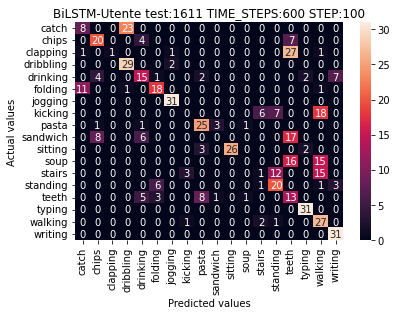

Utente test:  1614
Epoch 1/100
199/199 [==============================] - 30s 121ms/step - loss: 2.4675 - accuracy: 0.2043 - val_loss: 2.1174 - val_accuracy: 0.3017
Epoch 2/100
199/199 [==============================] - 23s 115ms/step - loss: 2.1424 - accuracy: 0.2959 - val_loss: 2.0866 - val_accuracy: 0.3018
Epoch 3/100
199/199 [==============================] - 23s 115ms/step - loss: 2.0253 - accuracy: 0.3241 - val_loss: 1.8776 - val_accuracy: 0.3746
Epoch 4/100
199/199 [==============================] - 23s 116ms/step - loss: 2.0043 - accuracy: 0.3369 - val_loss: 2.0408 - val_accuracy: 0.3160
Epoch 5/100
199/199 [==============================] - 23s 116ms/step - loss: 2.0173 - accuracy: 0.3343 - val_loss: 1.7976 - val_accuracy: 0.3974
Epoch 6/100
199/199 [==============================] - 23s 116ms/step - loss: 1.9097 - accuracy: 0.3601 - val_loss: 1.7373 - val_accuracy: 0.4094
Epoch 7/100
199/199 [==============================] - 23s 118ms/step - loss: 2.0408 - accuracy: 0.3303 -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.6977    0.9677    0.8108        31
           1     0.3333    0.3548    0.3438        31
           2     0.5741    1.0000    0.7294        31
           3     0.7857    0.3548    0.4889        31
           4     0.0000    0.0000    0.0000        31
           5     0.6279    0.8710    0.7297        31
           6     0.7750    1.0000    0.8732        31
           7     0.3167    0.6129    0.4176        31
           8     0.4909    0.8710    0.6279        31
           9     0.0000    0.0000    0.0000        31
          10     1.0000    1.0000    1.0000        31
          11     0.6667    0.7742    0.7164        31
          12     0.0000    0.0000    0.0000        31
          13     0.0000    0.0000    0.0000        31
          14     0.4412    0.4839    0.4615        31
          15     0.9688    1.0000    0.9841        31
          16     0.0000    0.0000    0.0000        31
          17     0.8158    

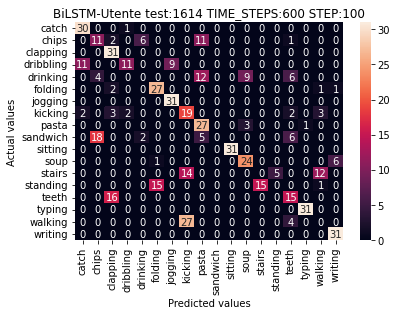

Utente test:  1615
Epoch 1/100
199/199 [==============================] - 30s 121ms/step - loss: 2.5014 - accuracy: 0.2027 - val_loss: 2.1473 - val_accuracy: 0.2962
Epoch 2/100
199/199 [==============================] - 23s 115ms/step - loss: 2.1621 - accuracy: 0.2923 - val_loss: 1.9106 - val_accuracy: 0.3580
Epoch 3/100
199/199 [==============================] - 23s 115ms/step - loss: 2.0777 - accuracy: 0.3119 - val_loss: 1.8687 - val_accuracy: 0.3691
Epoch 4/100
199/199 [==============================] - 23s 116ms/step - loss: 2.0232 - accuracy: 0.3218 - val_loss: 1.8254 - val_accuracy: 0.3748
Epoch 5/100
199/199 [==============================] - 23s 115ms/step - loss: 1.9829 - accuracy: 0.3369 - val_loss: 2.0080 - val_accuracy: 0.3358
Epoch 6/100
199/199 [==============================] - 23s 117ms/step - loss: 1.9588 - accuracy: 0.3409 - val_loss: 1.7247 - val_accuracy: 0.4087
Epoch 7/100
199/199 [==============================] - 23s 116ms/step - loss: 1.8399 - accuracy: 0.3760 -

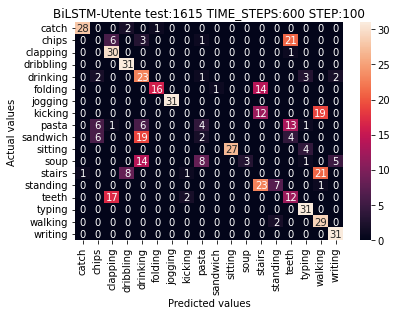

Utente test:  1616
Epoch 1/100
199/199 [==============================] - 30s 121ms/step - loss: 2.4592 - accuracy: 0.2205 - val_loss: 2.0958 - val_accuracy: 0.3149
Epoch 2/100
199/199 [==============================] - 23s 115ms/step - loss: 2.1356 - accuracy: 0.2943 - val_loss: 1.8865 - val_accuracy: 0.3590
Epoch 3/100
199/199 [==============================] - 23s 115ms/step - loss: 2.0346 - accuracy: 0.3233 - val_loss: 1.8681 - val_accuracy: 0.3738
Epoch 4/100
199/199 [==============================] - 23s 115ms/step - loss: 2.0321 - accuracy: 0.3241 - val_loss: 1.8141 - val_accuracy: 0.3656
Epoch 5/100
199/199 [==============================] - 23s 116ms/step - loss: 2.0357 - accuracy: 0.3191 - val_loss: 1.8942 - val_accuracy: 0.3570
Epoch 6/100
199/199 [==============================] - 23s 116ms/step - loss: 1.9584 - accuracy: 0.3389 - val_loss: 1.8325 - val_accuracy: 0.3875
Epoch 7/100
199/199 [==============================] - 23s 116ms/step - loss: 1.8976 - accuracy: 0.3547 -

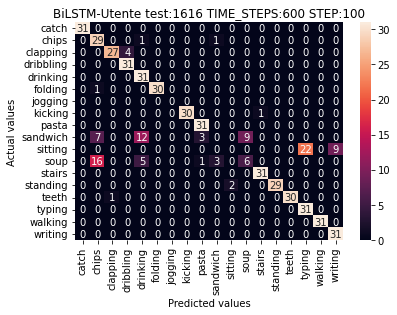

Utente test:  1619
Epoch 1/100
199/199 [==============================] - 30s 120ms/step - loss: 2.4539 - accuracy: 0.2107 - val_loss: 2.0457 - val_accuracy: 0.3163
Epoch 2/100
199/199 [==============================] - 23s 114ms/step - loss: 2.1654 - accuracy: 0.2893 - val_loss: 1.9112 - val_accuracy: 0.3628
Epoch 3/100
199/199 [==============================] - 23s 114ms/step - loss: 2.0200 - accuracy: 0.3246 - val_loss: 1.8516 - val_accuracy: 0.3803
Epoch 4/100
199/199 [==============================] - 23s 114ms/step - loss: 2.0154 - accuracy: 0.3297 - val_loss: 1.9630 - val_accuracy: 0.3630
Epoch 5/100
199/199 [==============================] - 23s 115ms/step - loss: 1.9820 - accuracy: 0.3427 - val_loss: 1.9147 - val_accuracy: 0.3540
Epoch 6/100
199/199 [==============================] - 23s 115ms/step - loss: 2.0086 - accuracy: 0.3305 - val_loss: 1.7494 - val_accuracy: 0.4240
Epoch 7/100
199/199 [==============================] - 23s 115ms/step - loss: 1.8349 - accuracy: 0.3809 -

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.9688    1.0000    0.9841        31
           1     0.4000    0.0645    0.1111        31
           2     0.5000    0.0323    0.0606        31
           3     1.0000    1.0000    1.0000        31
           4     0.4483    0.8387    0.5843        31
           5     0.7143    0.1613    0.2632        31
           6     1.0000    1.0000    1.0000        31
           7     0.5000    0.0323    0.0606        31
           8     0.1560    0.5484    0.2429        31
           9     0.0000    0.0000    0.0000        31
          10     0.0000    0.0000    0.0000        31
          11     0.0400    0.0323    0.0357        31
          12     0.8571    0.5806    0.6923        31
          13     0.9394    1.0000    0.9688        31
          14     0.9333    0.4516    0.6087        31
          15     0.7381    1.0000    0.8493        31
          16     0.4366    1.0000    0.6078        31
          17     0.4054    

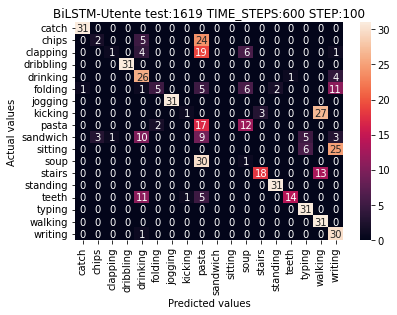

Utente test:  1623
Epoch 1/100
199/199 [==============================] - 30s 120ms/step - loss: 2.5047 - accuracy: 0.2059 - val_loss: 2.1192 - val_accuracy: 0.3232
Epoch 2/100
199/199 [==============================] - 23s 114ms/step - loss: 2.1806 - accuracy: 0.2932 - val_loss: 1.9583 - val_accuracy: 0.3440
Epoch 3/100
199/199 [==============================] - 23s 115ms/step - loss: 2.0288 - accuracy: 0.3209 - val_loss: 1.8692 - val_accuracy: 0.3749
Epoch 4/100
199/199 [==============================] - 23s 115ms/step - loss: 1.9479 - accuracy: 0.3423 - val_loss: 1.7645 - val_accuracy: 0.3870
Epoch 5/100
199/199 [==============================] - 23s 115ms/step - loss: 1.8748 - accuracy: 0.3719 - val_loss: 1.8044 - val_accuracy: 0.3806
Epoch 6/100
199/199 [==============================] - 23s 116ms/step - loss: 1.8232 - accuracy: 0.3828 - val_loss: 1.6236 - val_accuracy: 0.4440
Epoch 7/100
199/199 [==============================] - 23s 116ms/step - loss: 1.8413 - accuracy: 0.3846 -

In [ ]:
import itertools
import gc
bilstm_results_dict = []
bilstm_results = pd.DataFrame()

if bilstm_one_subject_out:

    for config in itertools.product(time_steps_list, step_list):

        time_step = config[0]
        step=config[1]

        bilstm_f1_weighted = []
        bilstm_f1_macro = []
        bilstm_acc = []
        bilstm_class_reports = []
        bilstm_confusion_matrixes = []

        print(time_step,step)

        for user_id in users_ids:
          if user_id not in notConsider:

              print("Utente test: ", user_id)

              X_test = np.array(data_cnn[time_step][step][user_id][0])
              y_test = np.array(data_cnn[time_step][step][user_id][1])

              X_train = []
              y_train = []

              for id in users_ids:
                  if id != user_id:
                      X_train += data_cnn[time_step][step][id][0]
                      y_train += data_cnn[time_step][step][id][1]
            
              X_train = np.array(X_train)
              y_train = np.array(y_train)

              y_train = enc.transform(y_train)
              y_test = enc.transform(y_test)

              scaler = RobustScaler()
              X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
              X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
            
            #X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
            #X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

              model = createBiLSTM([X_train[0].shape[0], X_train[0].shape[1]], y_train[0].shape[0])

              callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=True, restore_best_weights=True)

              XTraining, XValidation, YTraining, YValidation = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

              model.fit(XTraining, YTraining, batch_size = batchsize, epochs = 100, validation_data=(XValidation,YValidation), verbose=1, callbacks=[callback], shuffle=True )
            
              rounded_labels=np.argmax(y_test, axis=1)
              y_pred = np.argmax(model.predict(X_test), axis=-1)

              bilstm_acc.append(accuracy_score(rounded_labels, y_pred))
              bilstm_f1_weighted.append(f1_score(rounded_labels, y_pred, average='weighted'))
              bilstm_f1_macro.append(f1_score(rounded_labels, y_pred, average='macro'))
            #bilstm_f1.append(f1_m(rounded_labels,y_pred))

              class_report = classification_report(rounded_labels, y_pred, digits=4)
              print(class_report)
              bilstm_class_reports.append(class_report)
            
              conf_matrix = confusion_matrix(rounded_labels, y_pred, labels=range(0,len(enc.categories_[0])))

              ax = seaborn.heatmap(conf_matrix, annot=True, fmt='d')

              ax.set_title("BiLSTM-Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))

              ax.set_xlabel('Predicted values')
              ax.set_ylabel('Actual values')

              ax.xaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=90)
              ax.yaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=0)

              ax.get_figure().savefig(bilstm_plot_dir+'/'+ax.get_title().replace(":"," ")+".png", dpi=500)

              bilstm_confusion_matrixes.append(ax)
              plt.show()

              gc.collect()





            

        print("Accuracy media:",np.mean(bilstm_acc))
        print("F1 media macro:",np.mean(bilstm_f1_macro))
        print("F1 media weighted:",np.mean(bilstm_f1_macro))

        bilstm_results_dict.append({
            'Time Steps':time_step,
            'Step':step,
            'Average accuracy':np.mean(bilstm_acc),
            'Average F1 weighted': np.mean(bilstm_f1_weighted),
            'Average F1 macro': np.mean(bilstm_f1_macro),
            'reports':bilstm_class_reports,
            'confusion_matrix':bilstm_confusion_matrixes
        })

    bilstm_config_file = open(bilstm_config_filename, "a")
    model.summary(print_fn=lambda x: bilstm_config_file.write(x))
    bilstm_config_file.close()

In [ ]:
bilstm_results_dataframe = pd.DataFrame(bilstm_results_dict)
bilstm_results_dataframe.to_csv(bilstm_result_filename)
bilstm_results_dataframe

# SHALLOW LEARNING

## Random Forest

In [ ]:
rf_dir = folder_name + "\\rf"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

try:
    mkdir(rf_dir )
    mkdir(rf_dir + plot_dir)
except OSError as error:
    print(error)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 13.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.8s finished
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Us

                  precision    recall  f1-score   support

   NordicWalking       0.34      0.64      0.45       196
 ascendingStairs       0.43      0.89      0.58       148
         cycling       0.00      0.00      0.00       230
descendingStairs       0.12      0.05      0.07       138
         ironing       0.42      0.93      0.58       230
           lying       0.87      0.92      0.89       266
         running       1.00      0.95      0.97       205
         sitting       0.91      0.53      0.67       229
        standing       0.84      0.40      0.54       211
  vacuumCleaning       0.44      0.53      0.48       224
         walking       1.00      0.33      0.49       211

        accuracy                           0.57      2288
       macro avg       0.58      0.56      0.52      2288
    weighted avg       0.60      0.57      0.54      2288

f1:  0.5394500723681506
acc:  0.5729895104895105


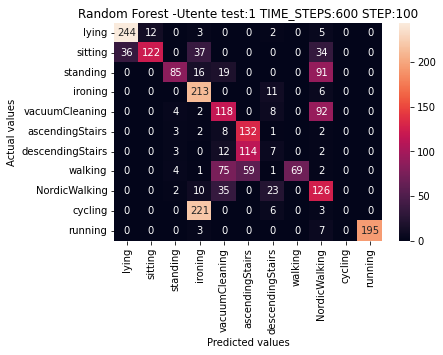

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

rf_results = []

gc.collect()
for config in itertools.product(time_steps_list, step_list):



    time_step = config[0]
    step=config[1]

    tuple = tuple_by_timestep[time_steps][step]

    f1_list = []
    acc_list = []

    for user_id in users_ids:

        x_test = tuple[user_id][0]
        y_test = tuple[user_id][1]

        x_train = []
        y_train = []

        for id in users_ids:
            if id != user_id:
                x_train+=tuple[id][0]
                y_train+=tuple[id][1]
        
        x_train = [x_train[i].flatten() for i in range(len(x_train)) ]
        x_test = [x_test[i].flatten() for i in range(len(x_test))]

        y_train = np.array(y_train).flatten()
        y_test = np.array(y_test).flatten()

        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        model = RandomForestClassifier(n_jobs=-1,n_estimators=1000,random_state=seed, verbose=True)

        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)

        conf_mat = confusion_matrix(y_test, y_pred, labels=classes)

        f1 = f1_score(y_test, y_pred, average='weighted')
        acc = accuracy_score(y_test, y_pred)

        print(classification_report(y_test, y_pred))

        ax = seaborn.heatmap(conf_mat, annot=True, fmt='d')

        ax.set_title("Random Forest -Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))
        ax.get_figure().savefig(rf_dir+plot_dir+'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
        ax.set_xlabel('Predicted values')
        ax.set_ylabel('Actual values')

        ax.xaxis.set_ticklabels(classes, rotation=90)
        ax.yaxis.set_ticklabels(classes, rotation=0)


        print("f1: ", f1)
        print("acc: ", acc)

        f1_list.append(f1)
        acc_list.append(acc)


        plt.show()
    
    print("F1 total: ", np.mean(f1_list))
    print("Accuracy total: ", np.mean(acc_list))

    rf_results.append({
    'Time Steps':time_step,
    'Step':step,
    'Average accuracy':np.mean(acc_list),
    'Average F1': np.mean(f1_list),
    })

rf_results_df = pd.DataFrame(rf_results)
rf_results_df.to_csv(rf_dir + result_filename)
print(rf_results_df)


## SVM

In [ ]:
svm_dir = folder_name + "\\svm"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

try:
    mkdir(svm_dir )
    mkdir(svm_dir + plot_dir)
except OSError as error:
    print(error)

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

svm_results = []

gc.collect()
for config in itertools.product(time_steps_list, step_list):

    time_step = config[0]
    step=config[1]

    tuple = tuple_by_timestep[time_steps][step]

    f1_macro_list = []
    f1_weighted_list = []
    acc_list = []

    for user_id in users_ids:

        x_test = tuple[user_id][0]
        y_test = tuple[user_id][1]

        x_train = []
        y_train = []

        for id in users_ids:
            if id != user_id:
                x_train+=tuple[id][0]
                y_train+=tuple[id][1]
        
        x_train = [x_train[i].flatten() for i in range(len(x_train)) ]
        x_test = [x_test[i].flatten() for i in range(len(x_test))]

        y_train = np.array(y_train).flatten()
        y_test = np.array(y_test).flatten()

        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        #model = RandomForestClassifier(n_jobs=-1,n_estimators=1000,random_state=seed, verbose=True)
        model = SVC(kernel='linear',random_state=seed, verbose=1)

        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)

        conf_mat = confusion_matrix(y_test, y_pred, labels=classes)

        f1_w = f1_score(y_test, y_pred, average='weighted')
        f1_m = f1_score(y_test, y_pred, average='macro')
        acc = accuracy_score(y_test, y_pred)

        print(classification_report(y_test, y_pred))

        ax = seaborn.heatmap(conf_mat, annot=True, fmt='d')

        ax.set_title("SVM -Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))
        ax.get_figure().savefig(svm_dir + plot_dir +'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
        ax.set_xlabel('Predicted values')
        ax.set_ylabel('Actual values')

        ax.xaxis.set_ticklabels(classes, rotation=90)
        ax.yaxis.set_ticklabels(classes, rotation=0)


        print("f1 macro: ", f1_m)
        print("f1 weighted: ", f1_w)
        print("acc: ", acc)

        f1_macro_list.append(f1_m)
        f1_weighted_list.append(f1_w)
        acc_list.append(acc)


        plt.show()
    
    print("F1 weighted total: ", np.mean(f1_weighted_list))
    print("F1 macro total: ", np.mean(f1_macro_list))
    print("Accuracy total: ", np.mean(acc_list))

    svm_results.append({
    'Time Steps':time_step,
    'Step':step,
    'Average accuracy':np.mean(acc_list),
    'Average F1 macro': np.mean(f1_macro_list),
    'Average F1 weighted': np.mean(f1_weighted_list)
    })

svm_results_df = pd.DataFrame(svm_results)
svm_results_df.to_csv(svm_dir + result_filename)
print(svm_results_df)



In [ ]:
svm_results_df

In [ ]:
print("F1 weighted total: ", np.mean(f1_weighted_list))
print("F1 macro total: ", np.mean(f1_macro_list))
print("Accuracy total: ", np.mean(acc_list))